# Cars 4 You: predictive price model

## Group Member Contribution

- Alexandre Coelho, 20250475:
- Bernardo Pacheco, 20250486:
- Bruna Sousa, 20250526:
- Rui Sousa 20250473:

## Abstract

## I. Identifying Business Needs

## II. Data Exploration and Preprocessing

### Load libraries

We began by loading the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'


In [2]:
from sklearn.model_selection import train_test_split,PredefinedSplit, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, Ridge, BayesianRidge
from sklearn.svm import LinearSVR
from sklearn.feature_selection import RFE
from sklearn.preprocessing import RobustScaler, TargetEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, ExtraTreesRegressor, \
    HistGradientBoostingRegressor
from sklearn.impute import  KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.utils import resample
from sklearn.base import clone

Loading our functions

In [3]:
# This allows Jupyter to detect changes in the .py file and reload them automatically without restarting the kernel
%load_ext autoreload
%autoreload 2

# Imports everything from 'functions_group23.py'.

try:
    from functions_group23 import *
    print("SUCCESS: Custom functions loaded correctly from 'my_functions.py'.")
except ImportError:
    print("ERROR: Could not find 'my_functions.py'. Make sure the file is in the same folder as this notebook.")

SUCCESS: Custom functions loaded correctly from 'my_functions.py'.


We started by loading and performing an in-depth analysis of the data quality to identify missing values, outliers, and formatting errors.

### Data loading and initial inspection

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [5]:
train.head(3)

carID   Brand   model    year  price transmission  mileage fuelType    tax  \
0  69512      VW    Golf  2016.0  22290    Semi-Auto  28421.0   Petrol    NaN   
1  53000  Toyota   Yaris  2019.0  13790       Manual   4589.0   Petrol  145.0   
2   6366    Audi      Q2  2019.0  24990    Semi-Auto   3624.0   Petrol  145.0   

         mpg  engineSize  paintQuality%  previousOwners  hasDamage  
0  11.417268         2.0           63.0             4.0        0.0  
1  47.900000         1.5           50.0             1.0        0.0  
2  40.900000         1.5           56.0             4.0        0.0

We can see that transmission is in the database but it wasn´t included in the metadata.

In [6]:
train.duplicated("carID").sum()

np.int64(0)

No carID duplicated, so we can define it as the index.

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


We can conclude that we have many strange values in all columns and some Dtypes are wrong (year and previousOwners).

In [8]:
train.describe().T

count          mean           std           min       25%  \
carID           75973.0  37986.000000  21931.660338      0.000000  18993.00   
year            74482.0   2017.096611      2.208704   1970.000000   2016.00   
price           75973.0  16881.889553   9736.926322    450.000000  10200.00   
mileage         74510.0  23004.184088  22129.788366 -58540.574478   7423.25   
tax             68069.0    120.329078     65.521176    -91.121630    125.00   
mpg             68047.0     55.152666     16.497837    -43.421768     46.30   
engineSize      74457.0      1.660136      0.573462     -0.103493      1.20   
paintQuality%   74449.0     64.590667     21.021065      1.638913     47.00   
previousOwners  74423.0      1.994580      1.472981     -2.345650      1.00   
hasDamage       74425.0      0.000000      0.000000      0.000000      0.00   

                    50%      75%            max  
carID           37986.0  56979.0   75972.000000  
year             2017.0   2019.0    2024.121759  
price           14699.0  20950.0  159999.000000  
mileage         17300.0  32427.5  323000.000000  
tax               145.0    145.0     580.000000  
mpg                54.3     62.8     470.800000  
engineSize          1.6      2.0       6.600000  
paintQuality%      65.0     82.0     125.594308  
previousOwners      2.0      3.0       6.258371  
hasDamage           0.0      0.0       0.000000

Here we can detect many strange values as:
    2024.121759 in the year column;
    -58540.574478 in the mileage column;
    -91.121630 in the tax column;
    -43.421768 in the mpg column;
    -0.103493 in the engineSize column;
    125.594308 in the paintQuality% column;
    -2.345650 in the previousOwners column;
    just zeros in the hasDamage column.

In [9]:
train.hasDamage.value_counts()

hasDamage
0.0    74425
Name: count, dtype: int64

By looking at this result, we can conclude that the stand only sells cars that have no damage at all.

In [10]:
metric_features = ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage']
non_metric_features = train.columns.drop(metric_features).to_list()
non_metric_features.remove("carID")
non_metric_features.remove("price")
train = create_new_features(train)
test = create_new_features(test)

metric_features.extend(['car_age', 'miles_per_year', 'power_efficiency'])

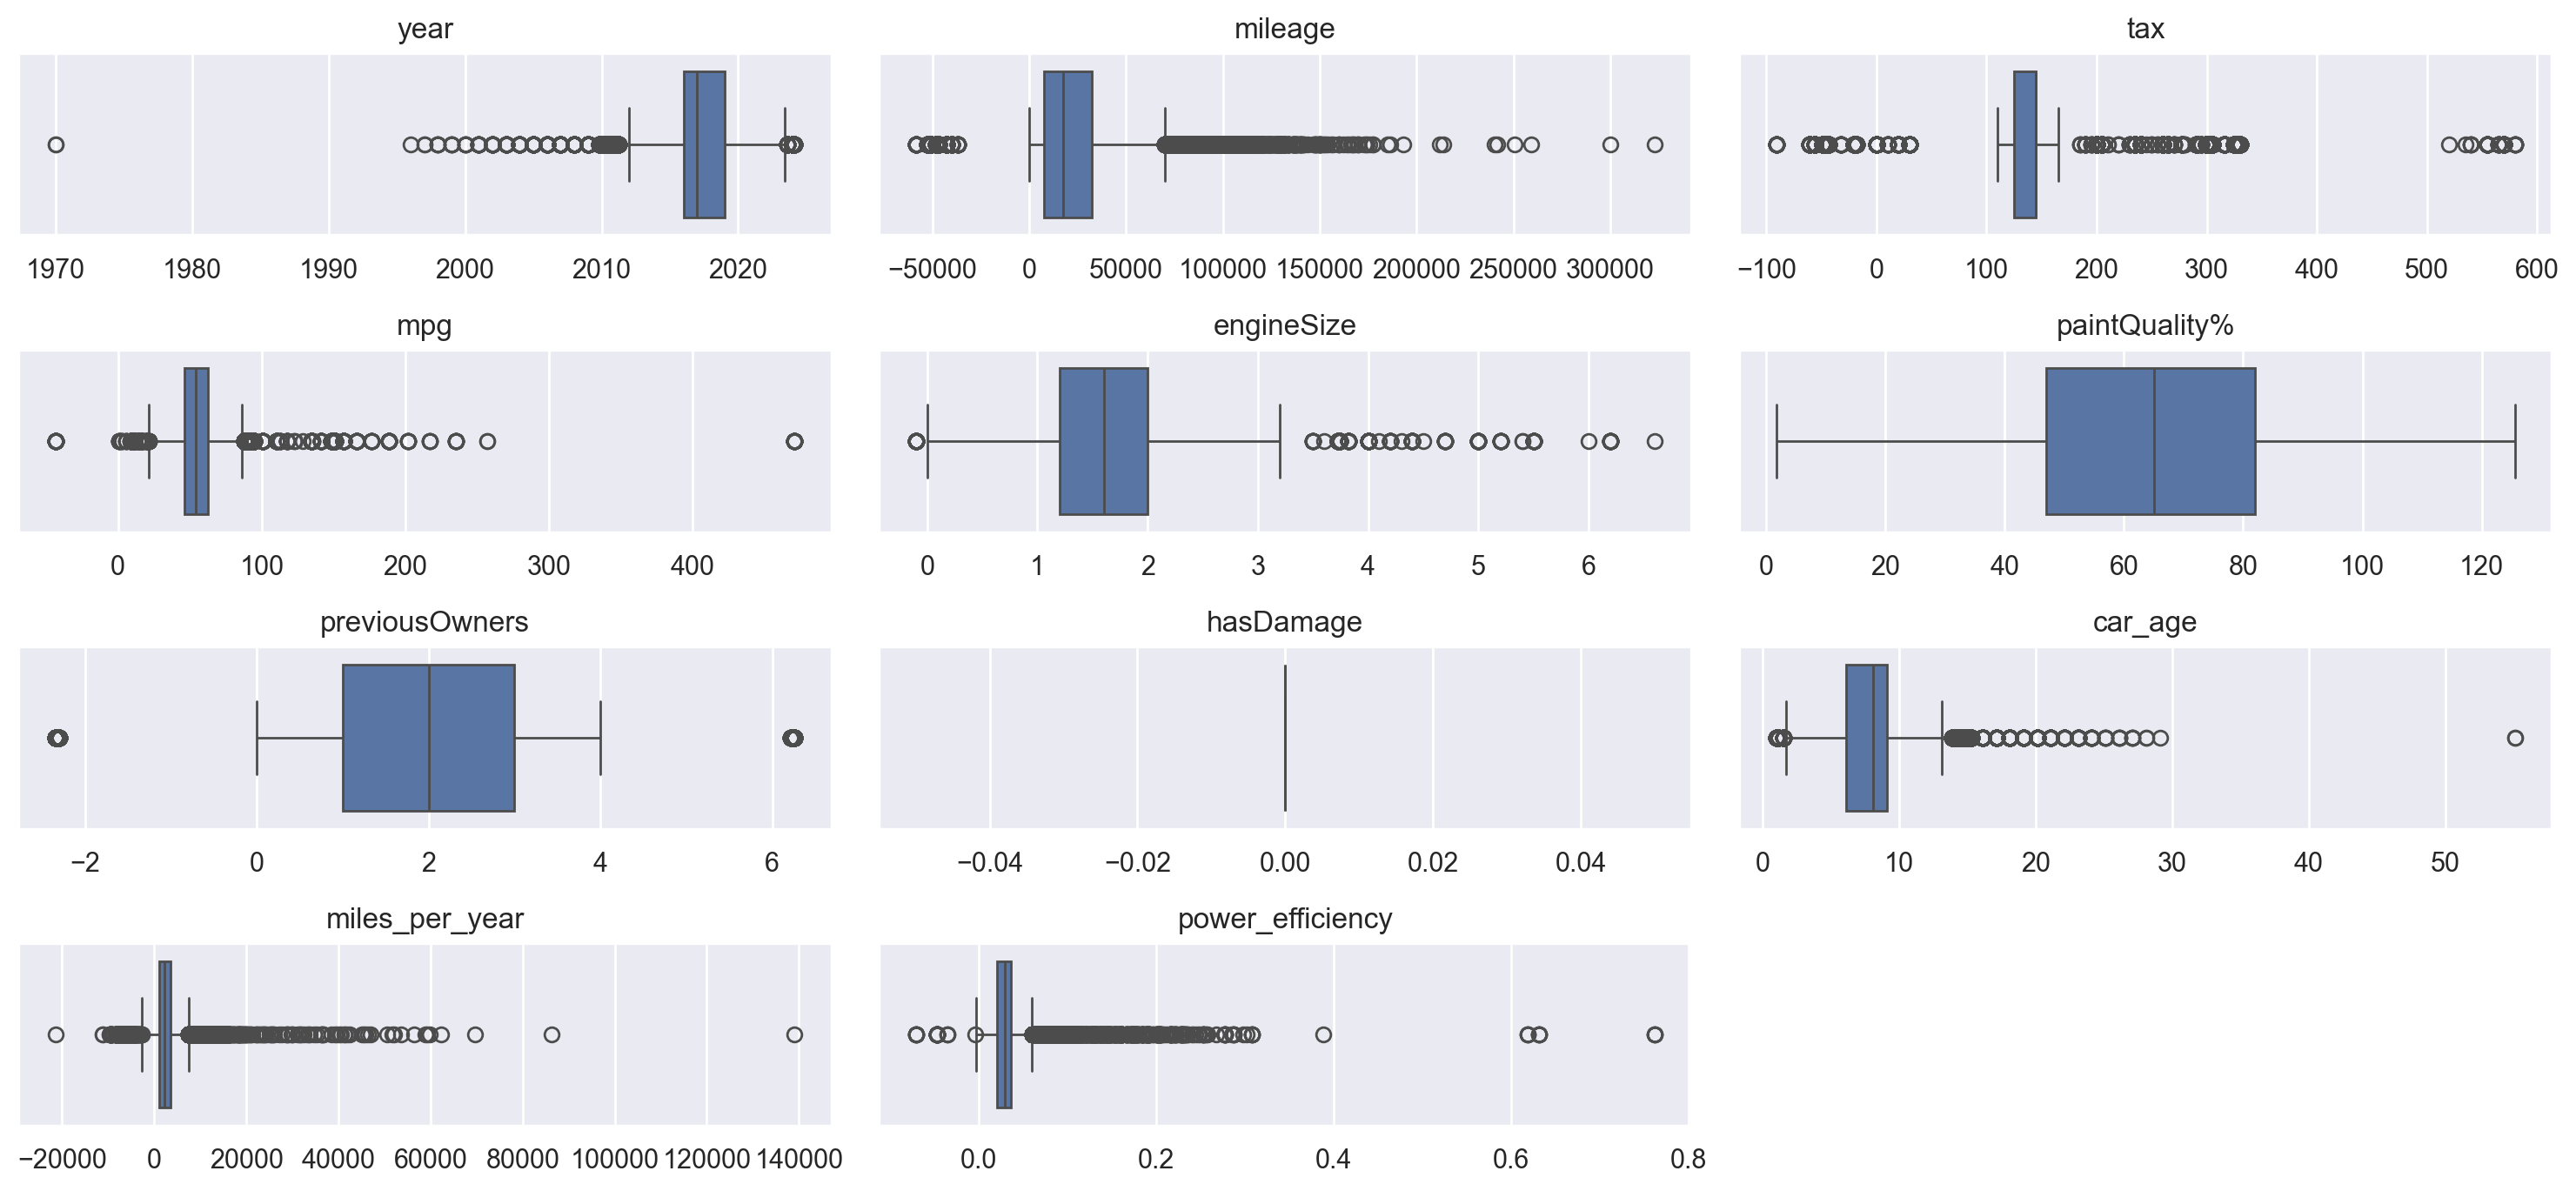

In [11]:
plt.figure(figsize=(15, 7))
for i, col in enumerate(metric_features):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(x=train[col])
    plt.title(col)
    plt.xlabel("")

plt.tight_layout()
plt.show()

### Missing values

In [12]:
print(train.isna().sum())

carID                  0
Brand               1521
model               1517
year                1491
price                  0
transmission        1522
mileage             1463
fuelType            1511
tax                 7904
mpg                 7926
engineSize          1516
paintQuality%       1524
previousOwners      1550
hasDamage           1548
car_age             1491
miles_per_year      2932
power_efficiency    9294
dtype: int64


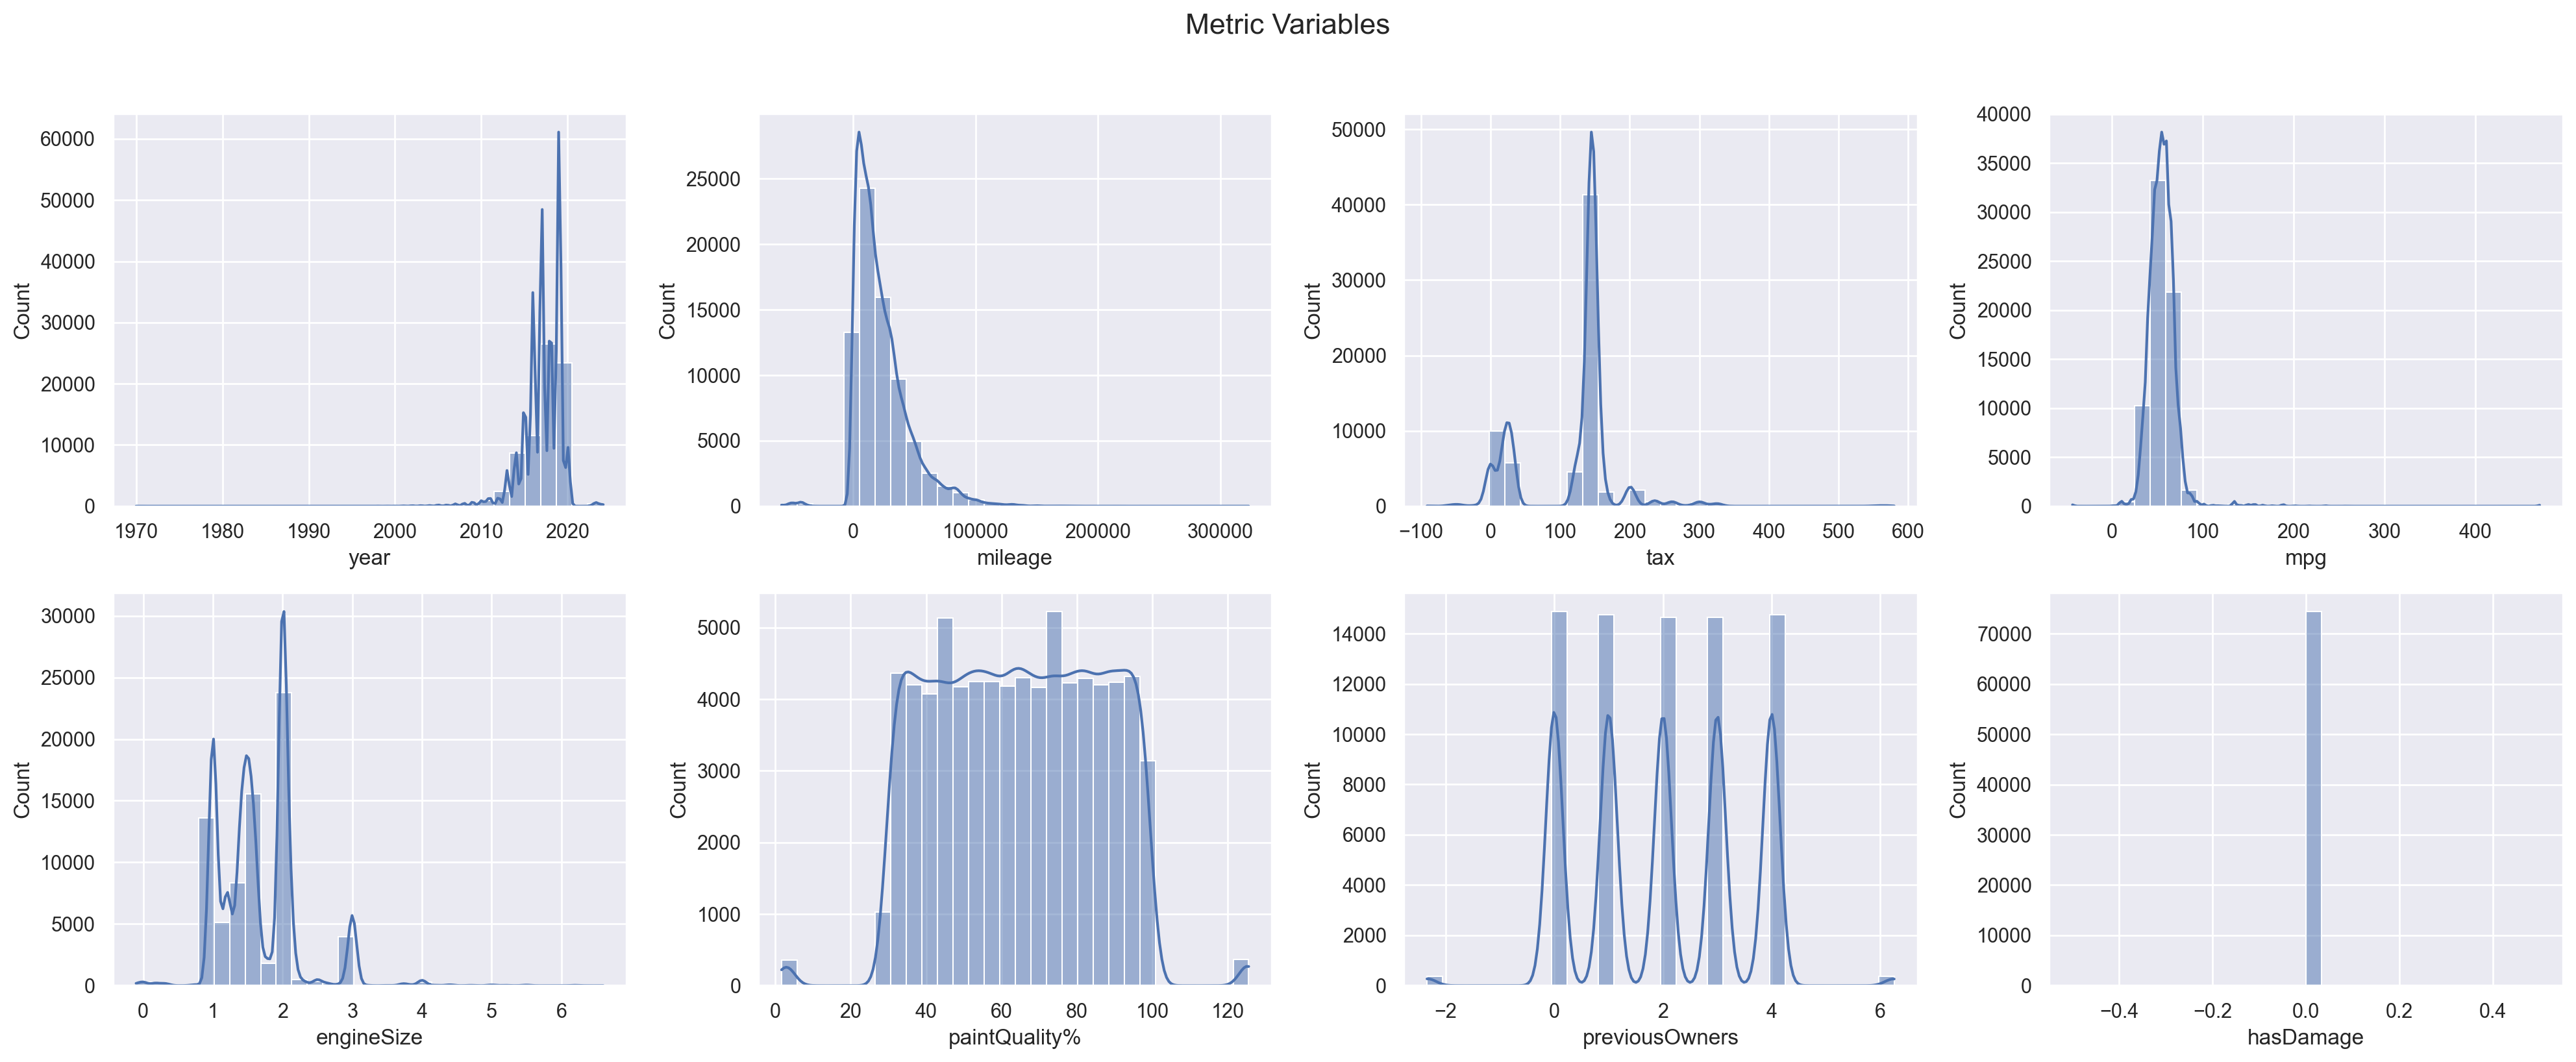

In [13]:
sp_rows = 2
sp_cols = 4

# Prepare figure and axes
fig, axes = plt.subplots(sp_rows, sp_cols, figsize=(20, 8), tight_layout=True)

# Plot data with seaborn
features = [f for f in metric_features]

for ax, feat in zip(axes.flatten(), features):
    sns.histplot(train[feat], bins=30, kde=True, ax=ax)

# Add a centered title to the figure
title = "Metric Variables"
fig.suptitle(title, fontsize=16, y=1.02)

plt.show()


From the histograms, we can observe that most of the metric variables are right-skewed and contain several outliers. Because of this non-normal distribution, replacing missing values with the median is more appropriate than using the mean, as the median is less affected by extreme values and better represents the central tendency of skewed data.

### Numerical feature cleaning

First, we defined functions to correct data types like year to Int64 and replace strange values (negative or >100%) with NaN.

In [14]:
metric_features.remove("hasDamage")
metric_features.remove("paintQuality%")

We removed hasDamage from metric_features list, as we decided to delete this column because it presented the same value in all rows.

We also removed paintQuality%, as it is described as a "mechanic's assessment," which means it would not be available to the model at the time a user submits car data for a price evaluation (the project's objective). 

In [15]:
X = [train, test]
for f in X:
    pre_processing_metric(f)

Found 369 strange values in mileage.
Found 4698 strange values in tax.
Found 151 strange values in mpg.
Found 264 strange values in engineSize.
Found 15250 strange values in previousOwners.
Found 170 strange values in mileage.
Found 1946 strange values in tax.
Found 74 strange values in mpg.
Found 126 strange values in engineSize.
Found 6388 strange values in previousOwners.


In [16]:
train.head(3)

Brand   model  year  price transmission  mileage fuelType    tax  \
carID                                                                      
69512      VW    Golf  2016  22290    Semi-Auto  28421.0   Petrol    NaN   
53000  Toyota   Yaris  2019  13790       Manual   4589.0   Petrol  145.0   
6366     Audi      Q2  2019  24990    Semi-Auto   3624.0   Petrol  145.0   

             mpg  engineSize  previousOwners   car_age  miles_per_year  \
carID                                                                    
69512  11.417268         2.0               4  9.121759     3081.949966   
53000  47.900000         1.5               1  6.121759      737.572761   
6366   40.900000         1.5               4  6.121759      582.471930   

       power_efficiency  
carID                    
69512          0.161066  
53000          0.030675  
6366           0.035800

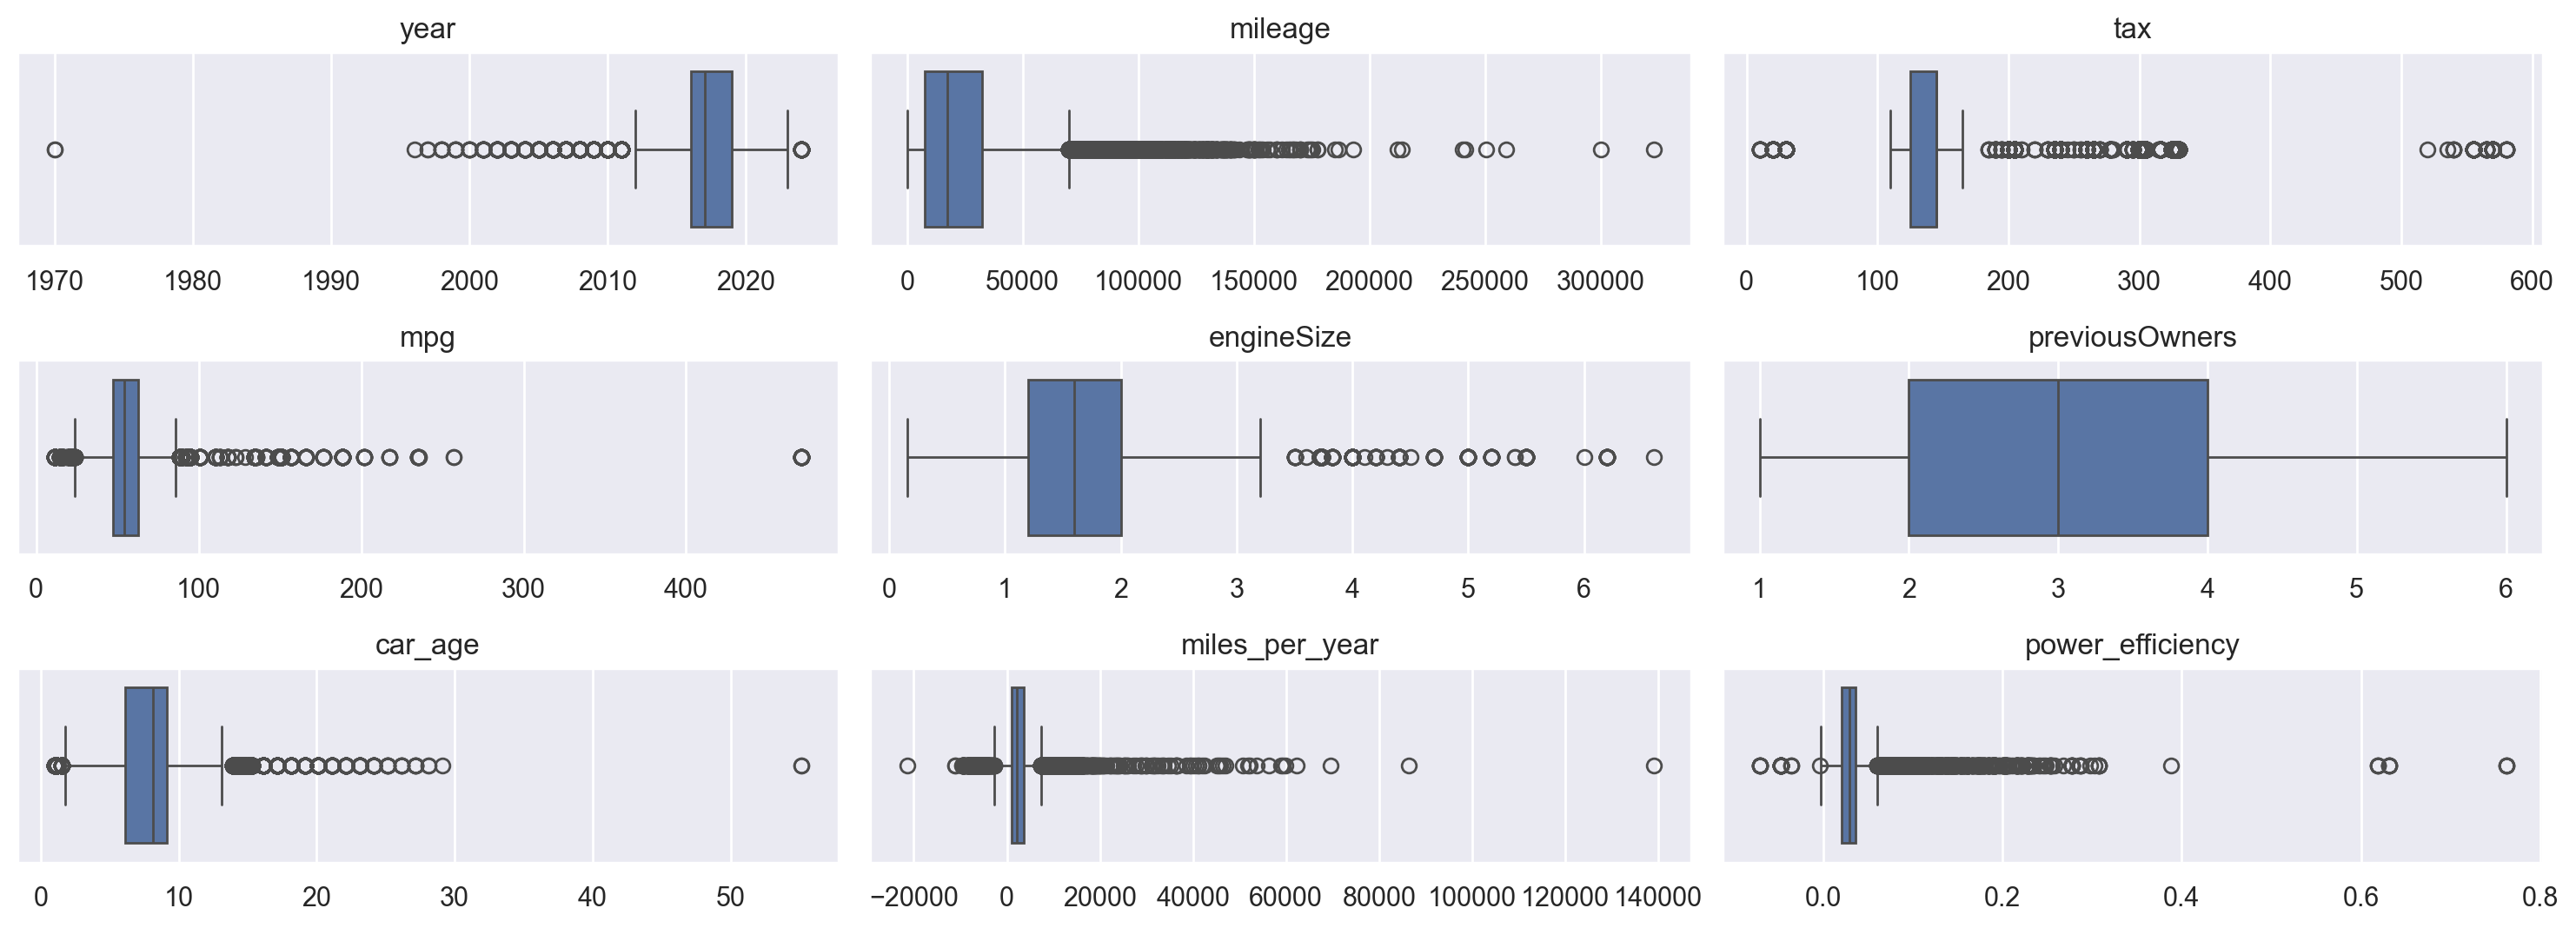

In [17]:
plt.figure(figsize=(15, 7))
for i, col in enumerate(metric_features):
    plt.subplot(4, 3, i + 1)  # Cria uma grelha 2x2
    sns.boxplot(x=train[col])
    plt.title(col)
    plt.xlabel("")

plt.tight_layout()
plt.show()

### Categorical feature cleaning

For text features like brand and transmission, we used rapidfuzz to standardize inconsistent entries (per example, "Ford" vs "ford") and fill remaining NaNs with "Unknown".

In [18]:
valid_brands_list = ["Ford", "Mercedes", "VW", "Opel", "BMW", "Audi", "Toyota", "Skoda", "Hyundai", "Unknown"]
valid_transmition_list = ["Manual", "Semi-Auto", "Automatic", "Other", "Unknown"]
valid_fueltype_list = ["Petrol", "Diesel", "Hybrid", "Other", "Electric", "Unknown"]
cols_change_dic = {"Brand": valid_brands_list,
                   "transmission": valid_transmition_list,
                   "fuelType": valid_fueltype_list
                   }

In [19]:
# Loop through both the training and testing DataFrames
for f in X:
    # Fill any NaNs in categorical columns with the string "Unknown"
    fill_nans_categorical(f, non_metric_features)
    # Apply the fuzzy matching and replacement logic to clean 'Brand', 'transmission', and 'fuelType'
    # This function iterates 3 times to clean the columns based on the valid lists in cols_change_dic
    pre_processing_non_metric(cols_change_dic, f)

Brand
Ford        16065
Mercedes    11674
VW          10385
Opel         9352
BMW          7392
Audi         7325
Toyota       4622
Skoda        4301
Hyundai      3336
Unknown      1521
Name: count, dtype: int64
transmission
Manual       41627
Semi-Auto    16872
Automatic    15211
Unknown       2258
Other            5
Name: count, dtype: int64
fuelType
Petrol      41163
Diesel      30885
Hybrid       2225
Unknown      1511
Other         167
Electric       22
Name: count, dtype: int64
Brand
Ford        6891
Mercedes    5004
VW          4466
Opel        4008
BMW         3174
Audi        3130
Toyota      1982
Skoda       1836
Hyundai     1427
Unknown      649
Name: count, dtype: int64
transmission
Manual       17889
Semi-Auto     7267
Automatic     6440
Unknown        968
Other            3
Name: count, dtype: int64
fuelType
Petrol      17488
Diesel      13395
Hybrid        936
Unknown       656
Other          82
Electric       10
Name: count, dtype: int64


In [20]:
# Build a master dictionary of all valid models associated with each valid brand
valid_models = valid_models_dict(train, valid_brands_list)

In [21]:
for f in X:
    # Now, clean the 'model' column one brand at a time for better accuracy
    for brand, valid_models_list in valid_models.items():
        # Select only the rows for the current brand
        brand_rows = f[f["Brand"] == brand]
        # Run the same fuzzy matching process, but only on the 'model' column for these rows,
        # using the brand-specific list of valid models as the reference.
        pre_processing_non_metric({"model": valid_models_list}, brand_rows)
        # Update the 'model' column in the main DataFrame with the newly cleaned data
        f.loc[brand_rows.index, "model"] = brand_rows["model"]

model
focus                    6756
fiesta                   4396
kuga                     1628
ecosport                  803
c-max                     378
ka+                       354
mondeo                    345
unknown                   324
b-max                     243
s-max                     197
grand c-max               147
galaxy                    143
edge                      134
puma                       51
tourneo custom             50
grand tourneo connect      41
mustang                    37
tourneo connect            20
fusion                     12
streetka                    2
fabia                       1
escort                      1
ranger                      1
octavia                     1
Name: count, dtype: int64
model
c class      5189
a class      1694
e class      1286
glc class     657
gla class     547
b class       412
cl class      324
gle class     322
unknown       230
sl class      177
cls class     153
v class       136
s class       129
gl class

In [22]:
# For any rows where 'Brand' is still 'Unknown', try to infer the brand
# by looking up its 'model' name in the master 'valid_models' dictionary.
for f in X:
    f = fill_unknown_brand(f, valid_models)

## III. Regression Benchmarking

### Data splitting (Hold-Out Method)

In [23]:
X_train_plot = train.copy()

In [24]:
X_train_val = train.drop('price', axis=1)
y_train_val = train['price']
X_test = test.copy()

We implemented the Hold-Out Method, splitting 'train.csv' into 75% for training (X_train) and 25% for validation (X_val).

In [25]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.25,
    random_state=21,
    shuffle=True
)

In [26]:
print('train:{}% | validation:{}%'.format(round(len(y_train) / len(y_train_val), 2),
                                          round(len(y_val) / len(y_train_val), 2), ))

train:0.75% | validation:0.25%


In [27]:
X_features = [X_train, X_val, X_test]

### Imputation and scaling

The impute_numeric_features function is responsible for handling missing data in the metric features. It uses the SimpleImputer from scikit-learn with the strategy='median'. This choice is based on the earlier observation that the data is right-skewed and contains outliers; the median is a more robust measure of central tendency than the mean in such cases.

In [28]:
X_features_imputed = impute_numeric_features(X_features, metric_features)

The scale_numeric_features function normalizes the numeric data after imputation. It employs the RobustScaler, which is specifically chosen because, like the median imputation, it is robust to outliers. This scaler removes the median and scales the data according to the interquartile range (IQR), which is appropriate for our non-normally distributed features.

In [29]:
X_train_scaled, X_val_scaled, X_test_scaled = scale_numeric_features(X_features_imputed, metric_features)
X_features_scaled = [X_train_scaled, X_val_scaled, X_test_scaled]
X_train_num_scaled = X_train_scaled[metric_features]
X_val_num_scaled = X_val_scaled[metric_features]

print(X_train_num_scaled.min())
print(X_train_num_scaled.max())

year               -15.666667
mileage             -0.709728
tax                 -6.750000
mpg                 -2.801448
engineSize          -1.806838
previousOwners      -1.500000
car_age             -2.373920
miles_per_year      -9.185215
power_efficiency    -6.343489
dtype: float64
year                 2.333333
mileage             11.374824
tax                 21.750000
mpg                 26.458599
engineSize           6.250000
previousOwners       3.500000
car_age             15.666667
miles_per_year      32.754035
power_efficiency    46.566760
dtype: float64


#### Attention: Preventing Data Leakage (Overfitting)
A critical rule in this pipeline is to prevent data leakage. The .fit() method, which is used to learn the parameters (like the median or the scaling range), must be called only on the X_train data.

The same fitted object is then used to .transform() all three datasets (X_train, X_val, and X_test). This ensures that no information from the validation or test sets "leaks" into the training process, which would otherwise lead to an overfitted model and an artificially optimistic performance score.


### Multivariate analysis 

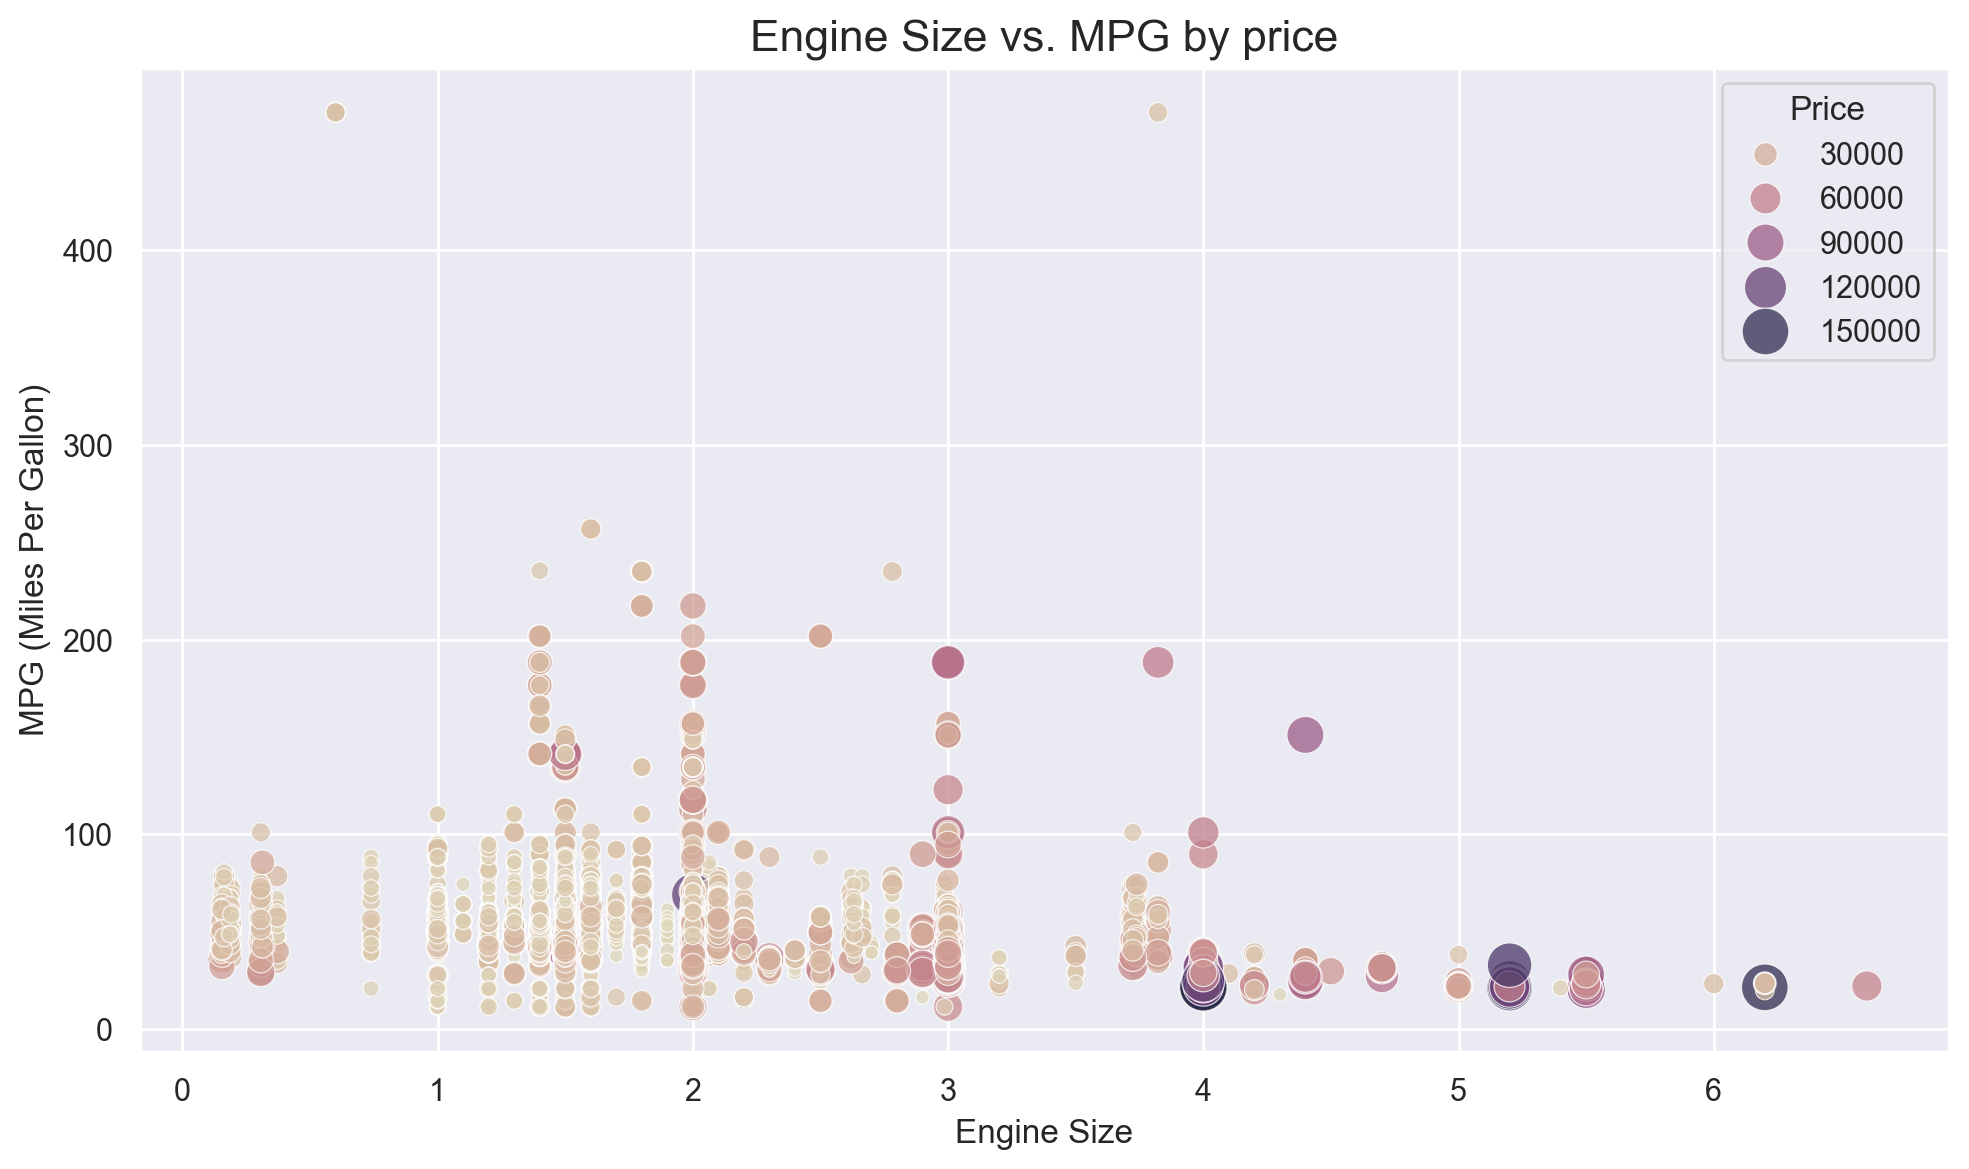

In [30]:
# Scatter Plot - Engine Size vs. MPG vs. Price

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=X_train_plot,
    x='engineSize',
    y='mpg',
    hue='price',
    palette='ch:s=-.4,r=.7',
    size='price',
    sizes=(20, 300),
    alpha=0.75
)
plt.title('Engine Size vs. MPG by price', fontsize=16)
plt.xlabel('Engine Size')
plt.ylabel('MPG (Miles Per Gallon)')
plt.legend(title='Price', loc='best')
plt.tight_layout()

plt.show()

The plot reveals a strong inverse relationship between Engine Size and MPG: larger engines mean lower fuel efficiency. Critically, the highest-priced vehicles are primarily characterized by larger engines and consequently lower MPG. This indicates that high-end consumers prioritize power over fuel economy. Both features are highly relevant for price prediction, even with their strong negative correlation.

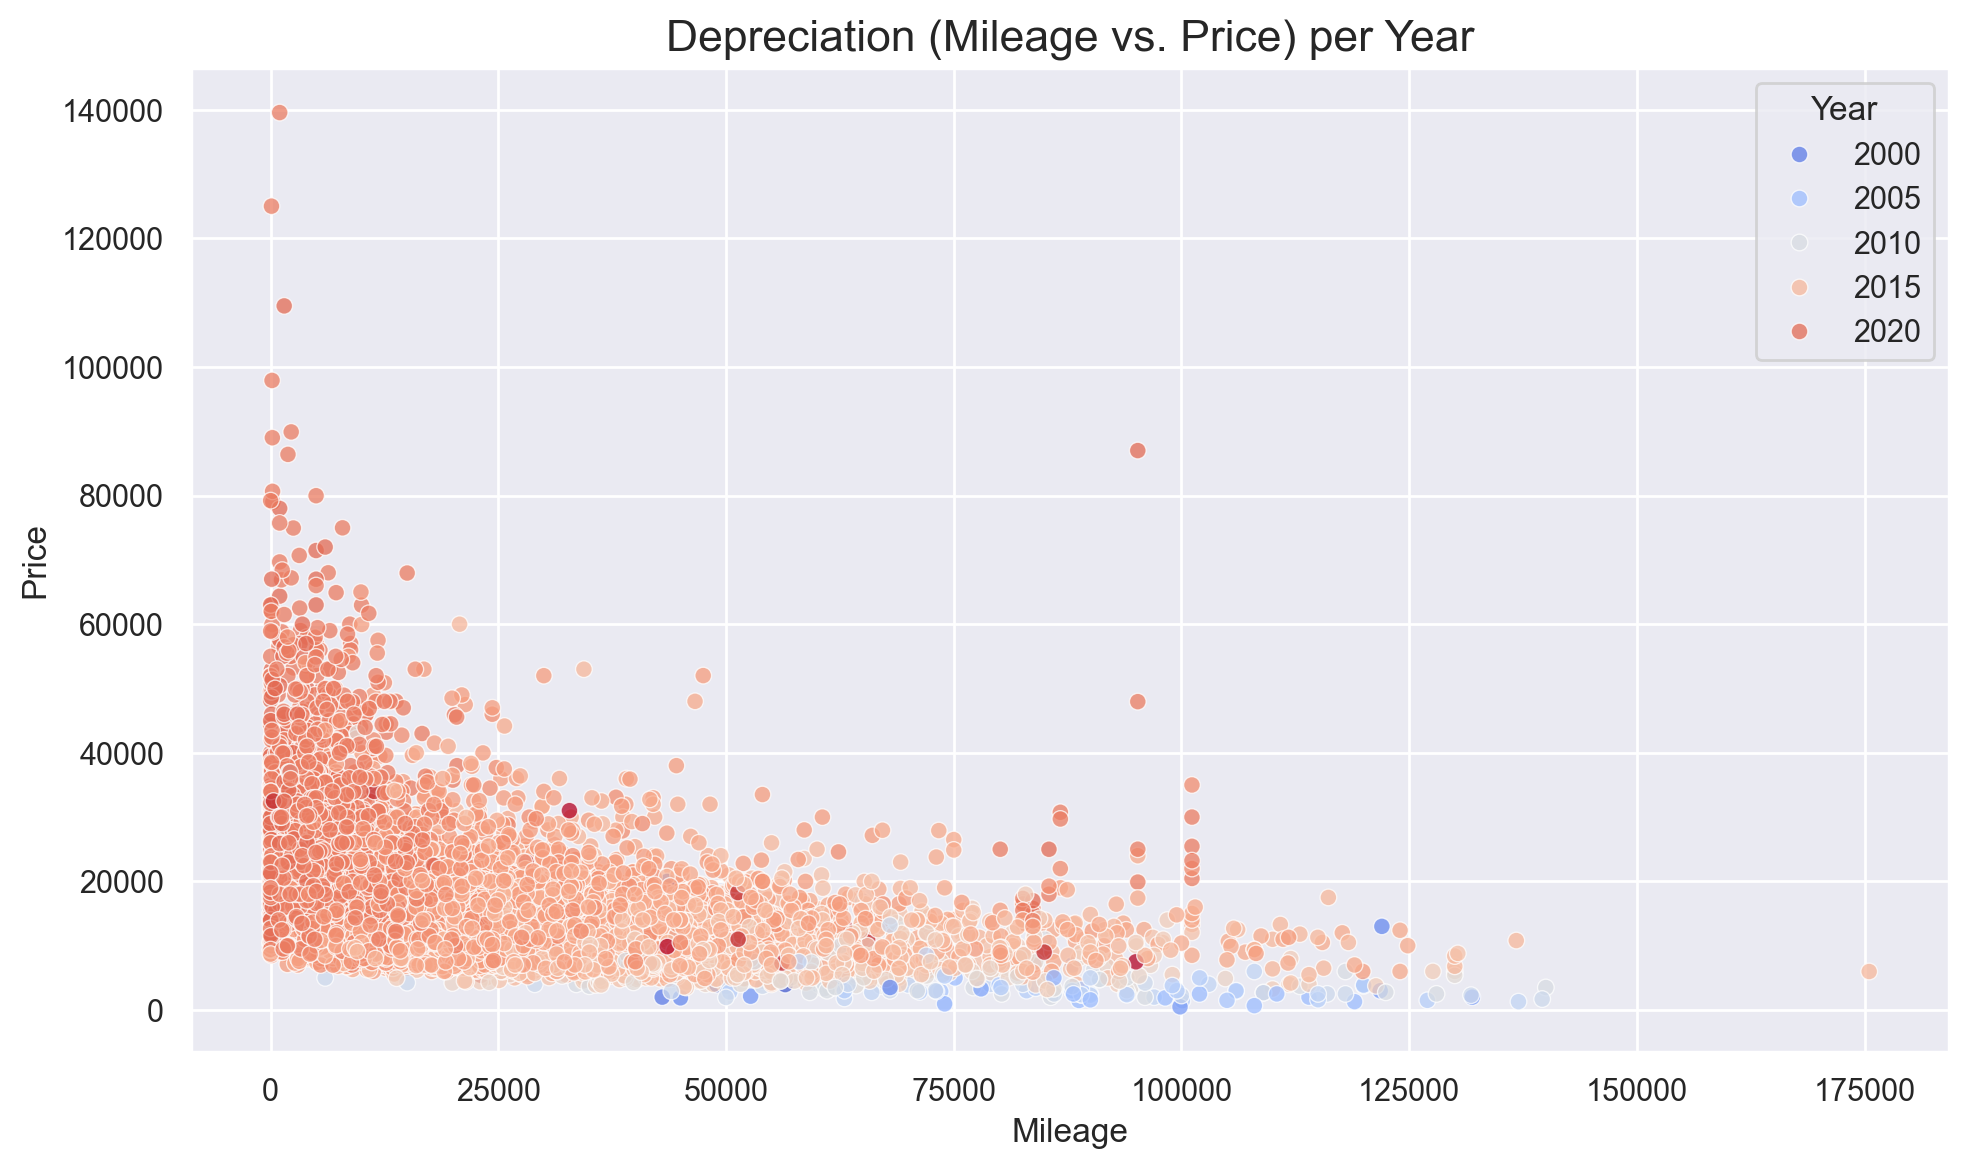

In [31]:
# Scatter Plot - Colour Depreciation per Year - Mileage vs. Price vs. Year
# Display 10k points so that the graph is not overloaded

train_plot_sample = X_train_plot.sample(n=min(10000, len(X_train_plot)), random_state=1).copy()
train_plot_sample['year'] = train_plot_sample['year'].astype(float)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=train_plot_sample,
    x='mileage',
    y='price',
    hue='year',
    palette='coolwarm',
    alpha=0.75
)
plt.title('Depreciation (Mileage vs. Price) per Year', fontsize=16)
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.legend(title='Year', loc='best')
plt.tight_layout()
plt.show()


Vehicle Year is the primary driver of depreciation, with newer cars (e.g., 2020) retaining significantly higher value than older ones, even with higher mileage. Mileage itself has an expected negative correlation with price, but Year's influence is more profound.

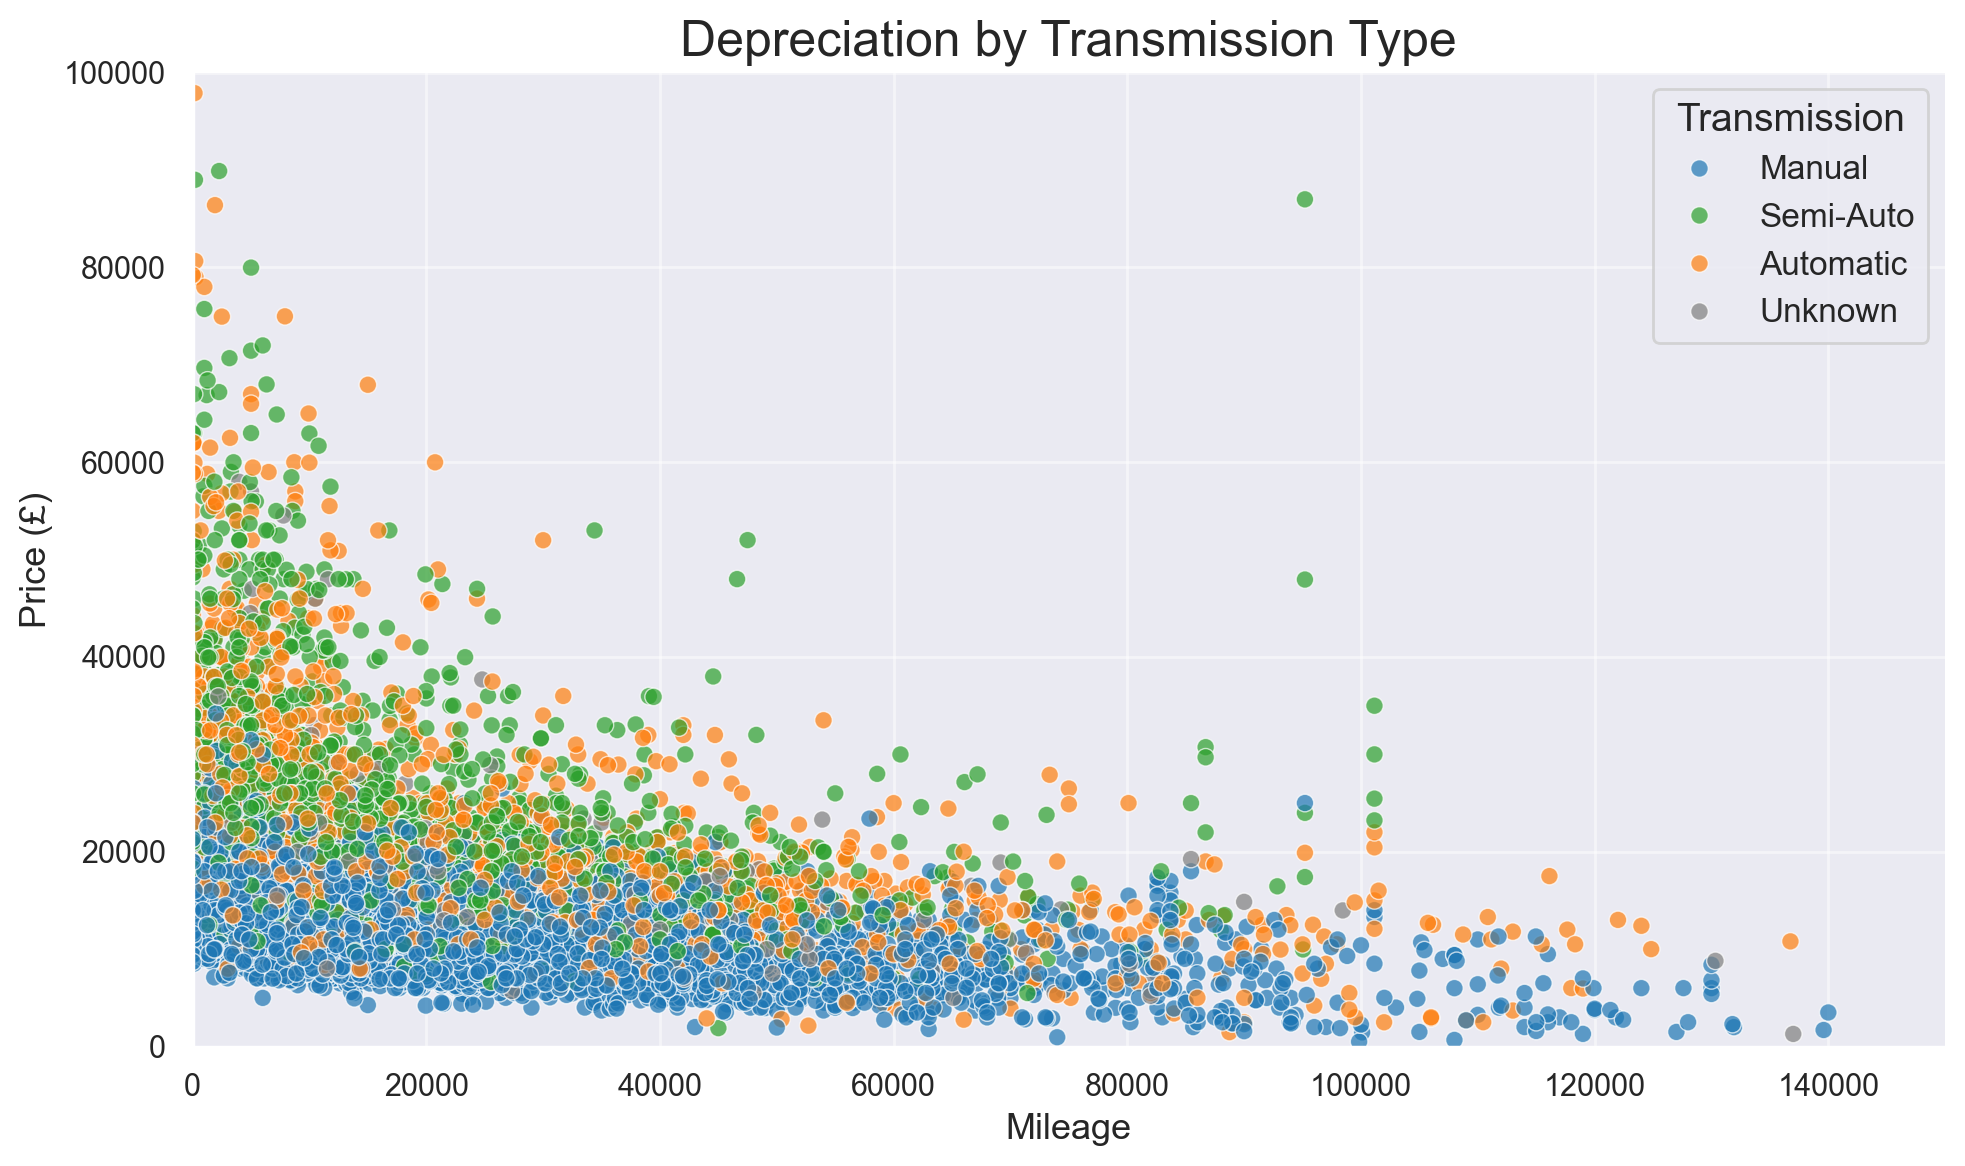

In [32]:
# Regression Chart (Mileage vs. Price vs. Transmission)
# Sample data to keep it light
sample = X_train_plot.sample(n=min(10000, len(X_train_plot)), random_state=1).copy()

# Balanced, colorblind-safe palette
palette = {
    'Manual': '#1f77b4',  # blue
    'Automatic': '#ff7f0e',  # orange
    'Semi-Auto': '#2ca02c',  # green
    'Other': '#9467bd',  # purple
    'Unknown': '#7f7f7f'  # gray
}

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=sample,
    x='mileage',
    y='price',
    hue='transmission',
    palette=palette,
    alpha=0.7,
    s=40
)

# Titles & labels
plt.title('Depreciation by Transmission Type', fontsize=18)
plt.xlabel('Mileage', fontsize=13)
plt.ylabel('Price (£)', fontsize=13)

# Axis limits for focus
plt.xlim(0, 150000)
plt.ylim(0, 100000)

# Clean style
sns.despine()
plt.grid(True, linestyle='-', alpha=0.5)

# Legend styling
plt.legend(title='Transmission', title_fontsize=14, fontsize=12, loc='best')

plt.tight_layout()
plt.show()


Automatic and Semi-Auto transmissions consistently command a higher price point than Manual transmissions across all mileage ranges, indicating their superior market value.

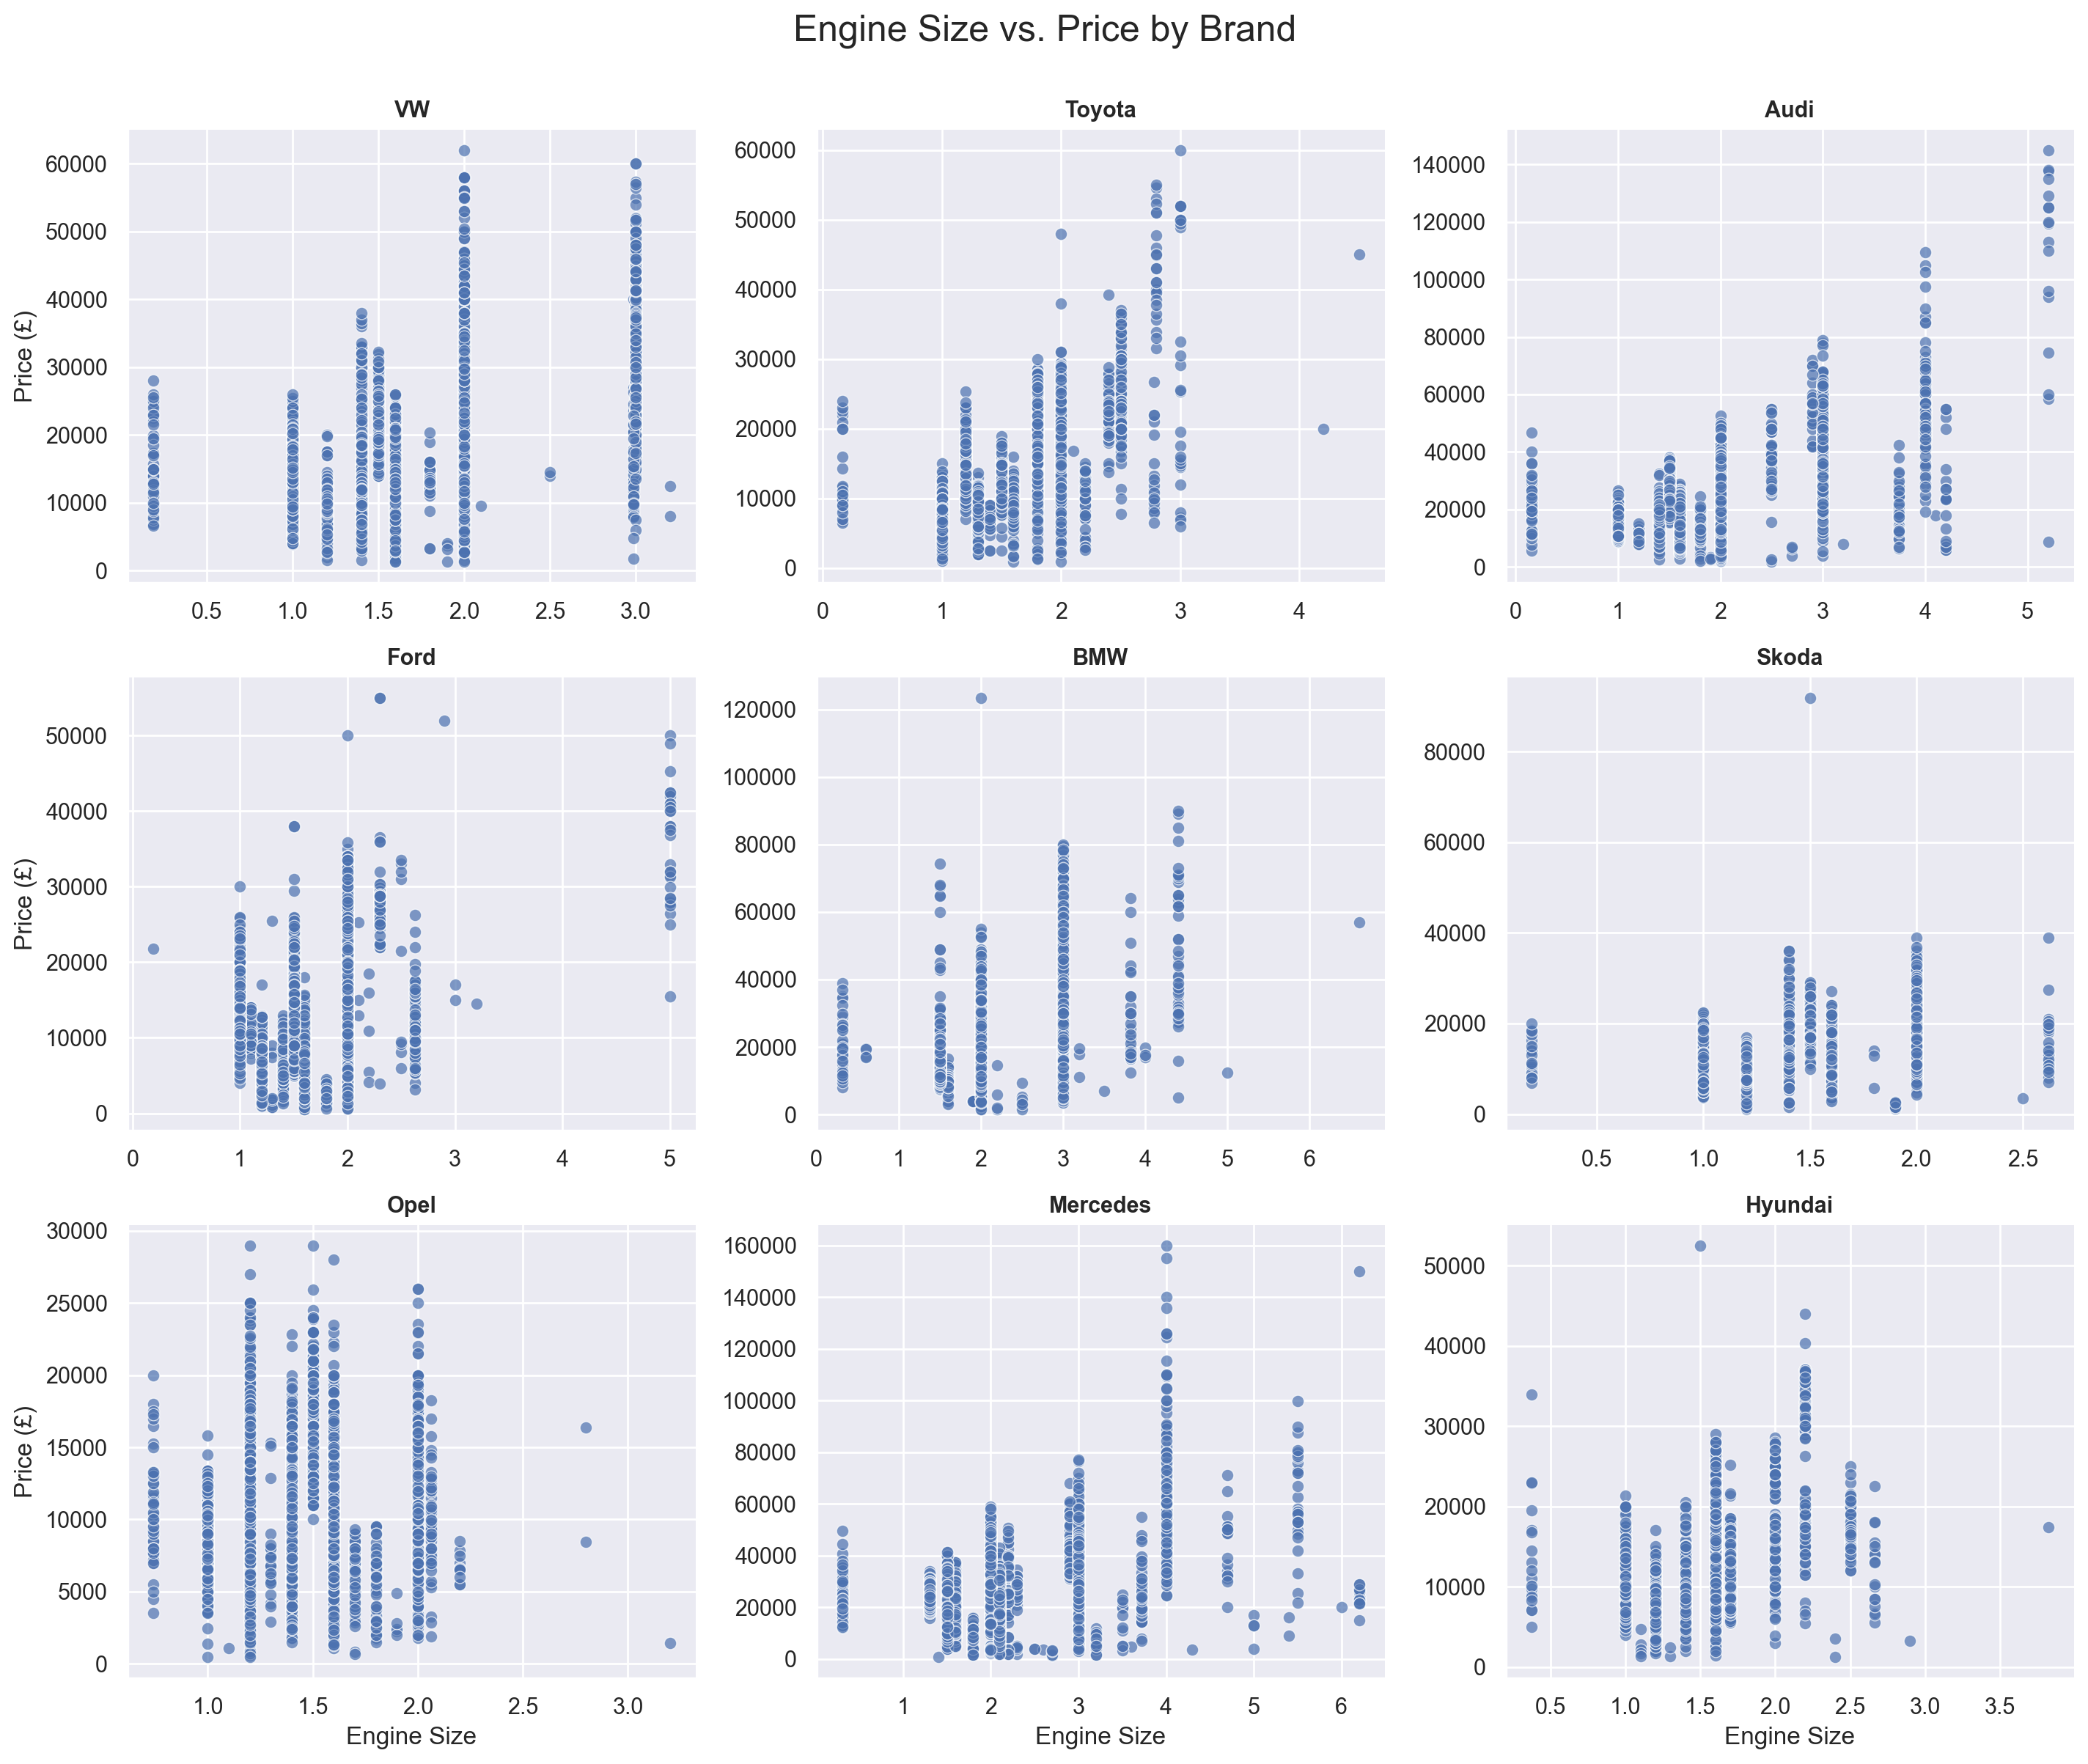

In [33]:
# Scatter Plot - Engine Size vs. Price vs. Brand

g = sns.relplot(
    data=X_train_plot,
    x='engineSize',
    y='price',
    col='Brand',
    col_wrap=3,
    kind='scatter',
    facet_kws={'sharey': False, 'sharex': False},
    alpha=0.7,
    height=4,
    aspect=1.2
)

for ax in g.axes.flat:
    title = ax.get_title()
    clean_title = title.replace('Brand = ', '')
    ax.set_title(clean_title, fontsize=11, fontweight='bold')

g.fig.suptitle('Engine Size vs. Price by Brand', fontsize=18, y=1)
g.set_axis_labels('Engine Size', 'Price (£)')

sns.despine()
plt.tight_layout()
plt.show()


Higher Engine Size strongly correlates with higher prices, especially for premium brands, despite often resulting in lower MPG. The most expensive vehicles are typically those with larger, less fuel-efficient engines.

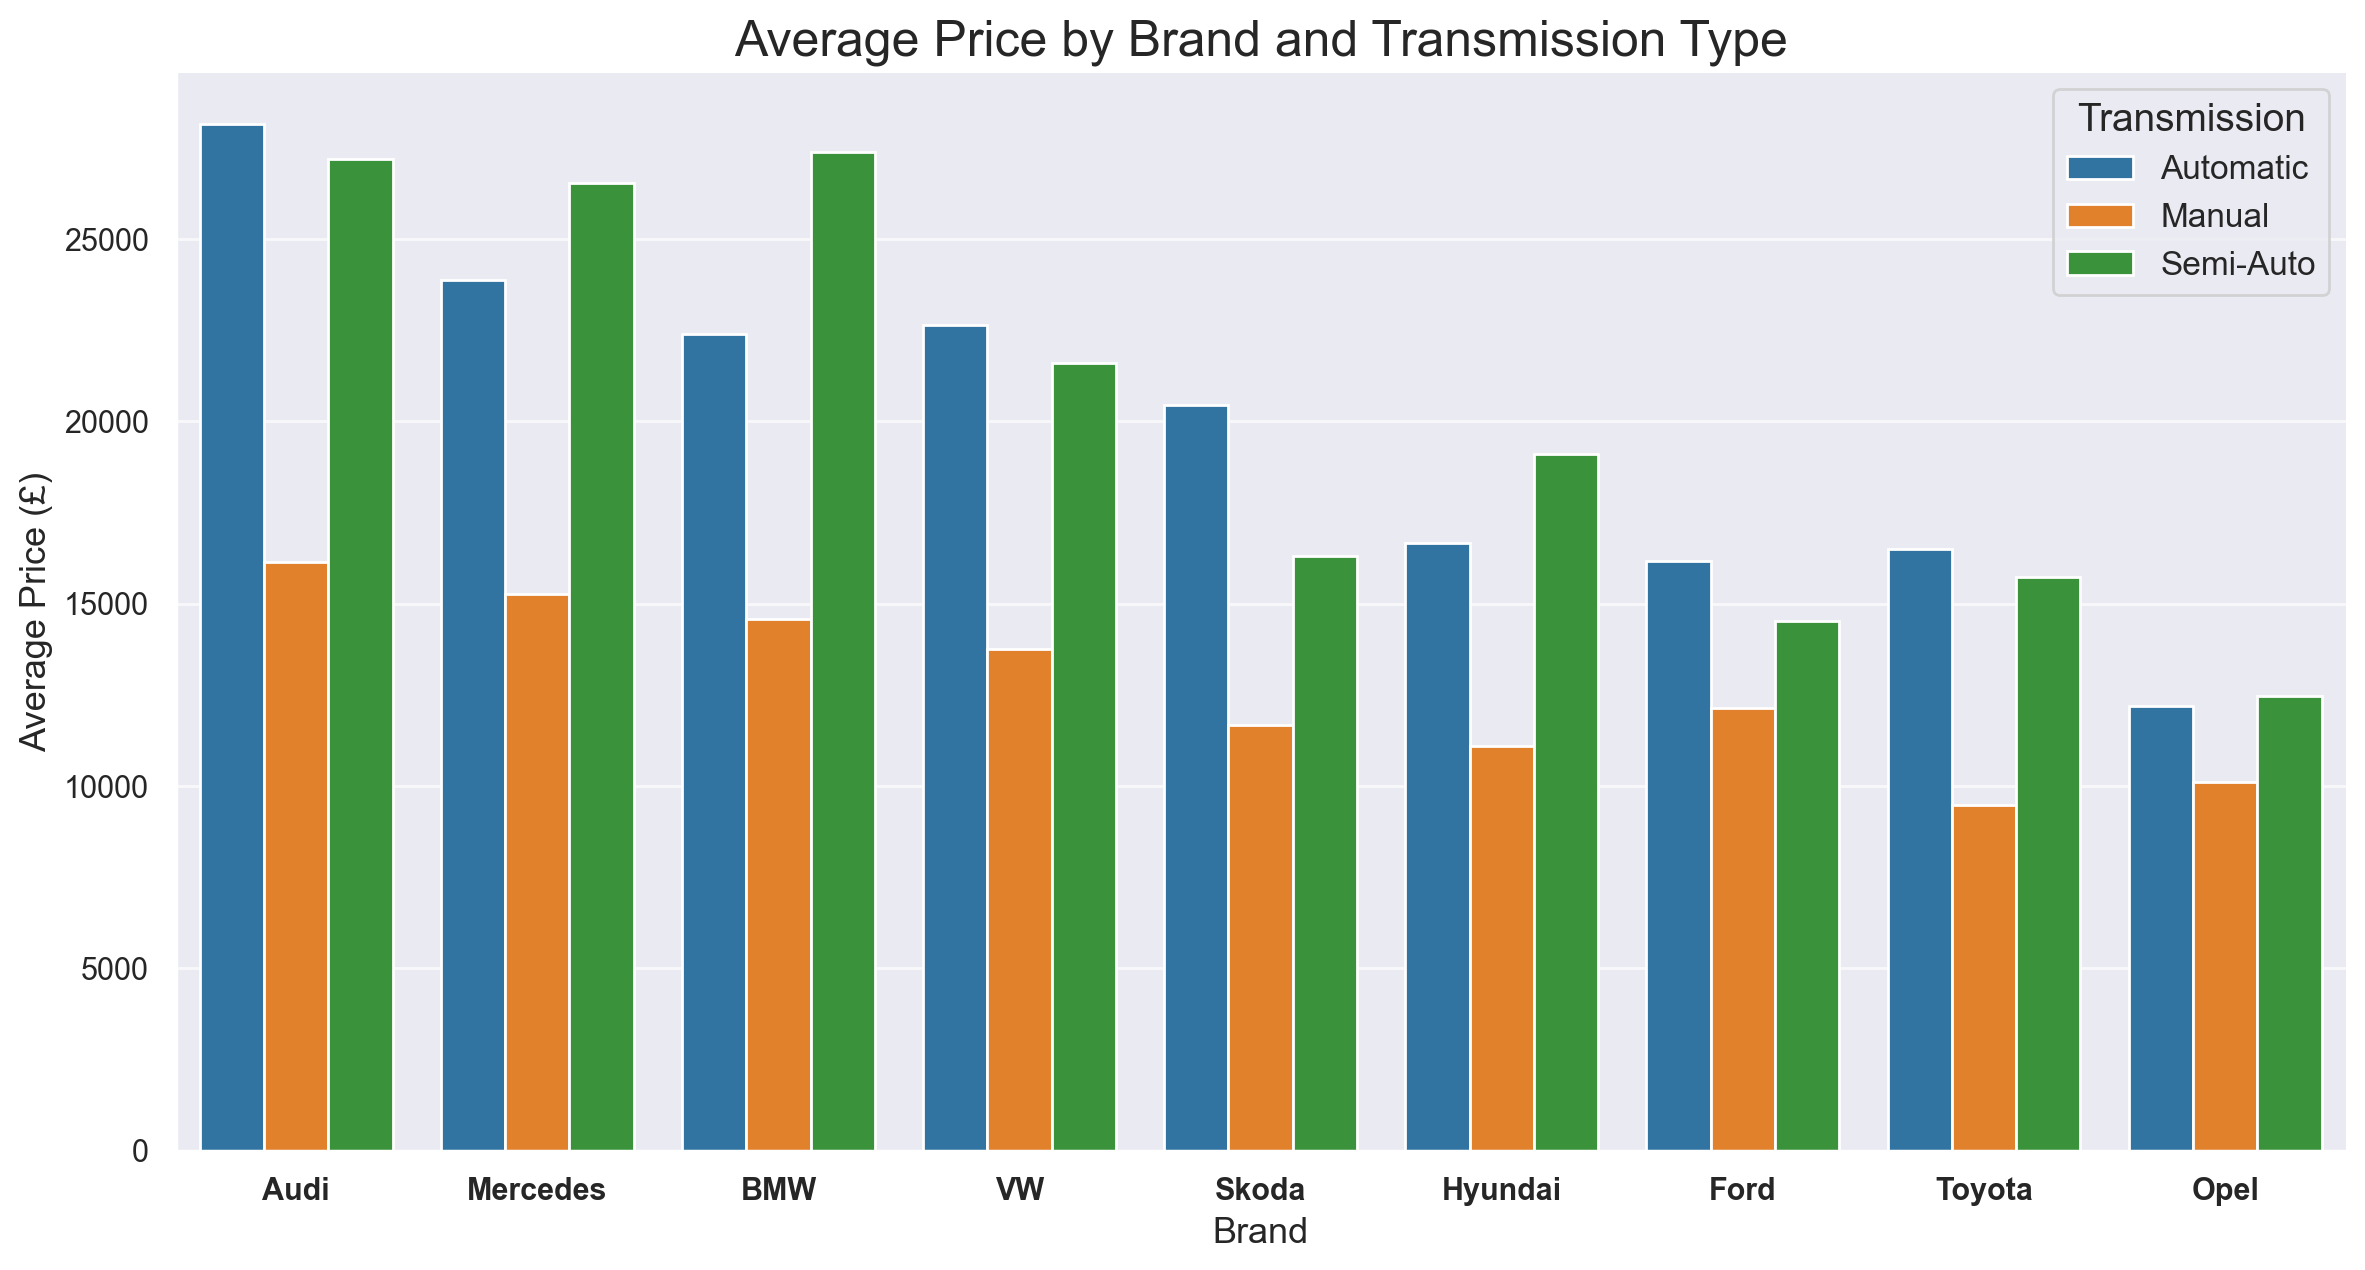

In [34]:
# Grouped Bar Chart (Brand vs. Price vs. Transmission)
# Filter out 'Other' and 'Unknown'
df_filtered = X_train_plot[X_train_plot['transmission'].isin(['Automatic', 'Manual', 'Semi-Auto'])]

# Compute mean price by Brand and Transmission
avg_prices = (
    df_filtered
    .groupby(['Brand', 'transmission'], as_index=False)['price']
    .mean()
)

# Sort brands by overall average price
brand_order = (
    avg_prices.groupby('Brand')['price']
    .mean()
    .sort_values(ascending=False)
    .index
)

palette = {
    'Automatic': '#1f77b4',  # blue
    'Manual': '#ff7f0e',  # orange
    'Semi-Auto': '#2ca02c'  # green
}

plt.figure(figsize=(14, 7))
sns.barplot(
    data=avg_prices,
    x='Brand',
    y='price',
    hue='transmission',
    hue_order=['Automatic', 'Manual', 'Semi-Auto'],
    order=brand_order,
    palette=palette
)

# Titles & labels
plt.title('Average Price by Brand and Transmission Type', fontsize=18)
plt.xlabel('Brand', fontsize=13)
plt.ylabel('Average Price (£)', fontsize=13)

plt.xticks(fontweight='bold')

# Legend styling
plt.legend(
    title='Transmission',
    title_fontsize=14,
    fontsize=12,
    loc='upper right',

)

# Grid & style
sns.despine()
plt.grid(axis='y', linestyle='-', alpha=0.7)

plt.show()



Brand plays a critical role, fundamentally altering the Engine size-price relationship. While volume brands show a less distinct pattern, premium brands (e.g., Audi, Mercedes) exhibit a clear, strong positive correlation between larger Engine Size and significantly higher Price. This highlights the necessity of advanced categorical encoding like TargetEncoder to capture these complex brand-specific dynamics.

### Feature selection

In [35]:
X_train_num_scaled[metric_features].var()

year                0.531515
mileage             0.753937
tax                 7.812066
mpg                 1.067370
engineSize          0.490575
previousOwners      1.054216
car_age             0.530451
miles_per_year      1.081910
power_efficiency    1.791580
dtype: float64

#### Filter methods

##### Spearman correlation

In [36]:
cor_spearman = X_train_num_scaled.corr(method='spearman')
cor_spearman

year   mileage       tax       mpg  engineSize  \
year              1.000000 -0.780953  0.344085 -0.333343   -0.044812   
mileage          -0.780953  1.000000 -0.274202  0.340040    0.104991   
tax               0.344085 -0.274202  1.000000 -0.505636    0.120151   
mpg              -0.333343  0.340040 -0.505636  1.000000   -0.184973   
engineSize       -0.044812  0.104991  0.120151 -0.184973    1.000000   
previousOwners    0.013644 -0.010240 -0.005546  0.006441   -0.030230   
car_age          -0.999999  0.780995 -0.344073  0.333330    0.044805   
miles_per_year   -0.641789  0.931439 -0.229576  0.315084    0.100742   
power_efficiency  0.135560 -0.095443  0.351482 -0.660569    0.818097   

                  previousOwners   car_age  miles_per_year  power_efficiency  
year                    0.013644 -0.999999       -0.641789          0.135560  
mileage                -0.010240  0.780995        0.931439         -0.095443  
tax                    -0.005546 -0.344073       -0.229576          0.351482  
mpg                     0.006441  0.333330        0.315084         -0.660569  
engineSize             -0.030230  0.044805        0.100742          0.818097  
previousOwners          1.000000 -0.013642       -0.007852         -0.026223  
car_age                -0.013642  1.000000        0.641853         -0.135558  
miles_per_year         -0.007852  0.641853        1.000000         -0.085963  
power_efficiency       -0.026223 -0.135558       -0.085963          1.000000

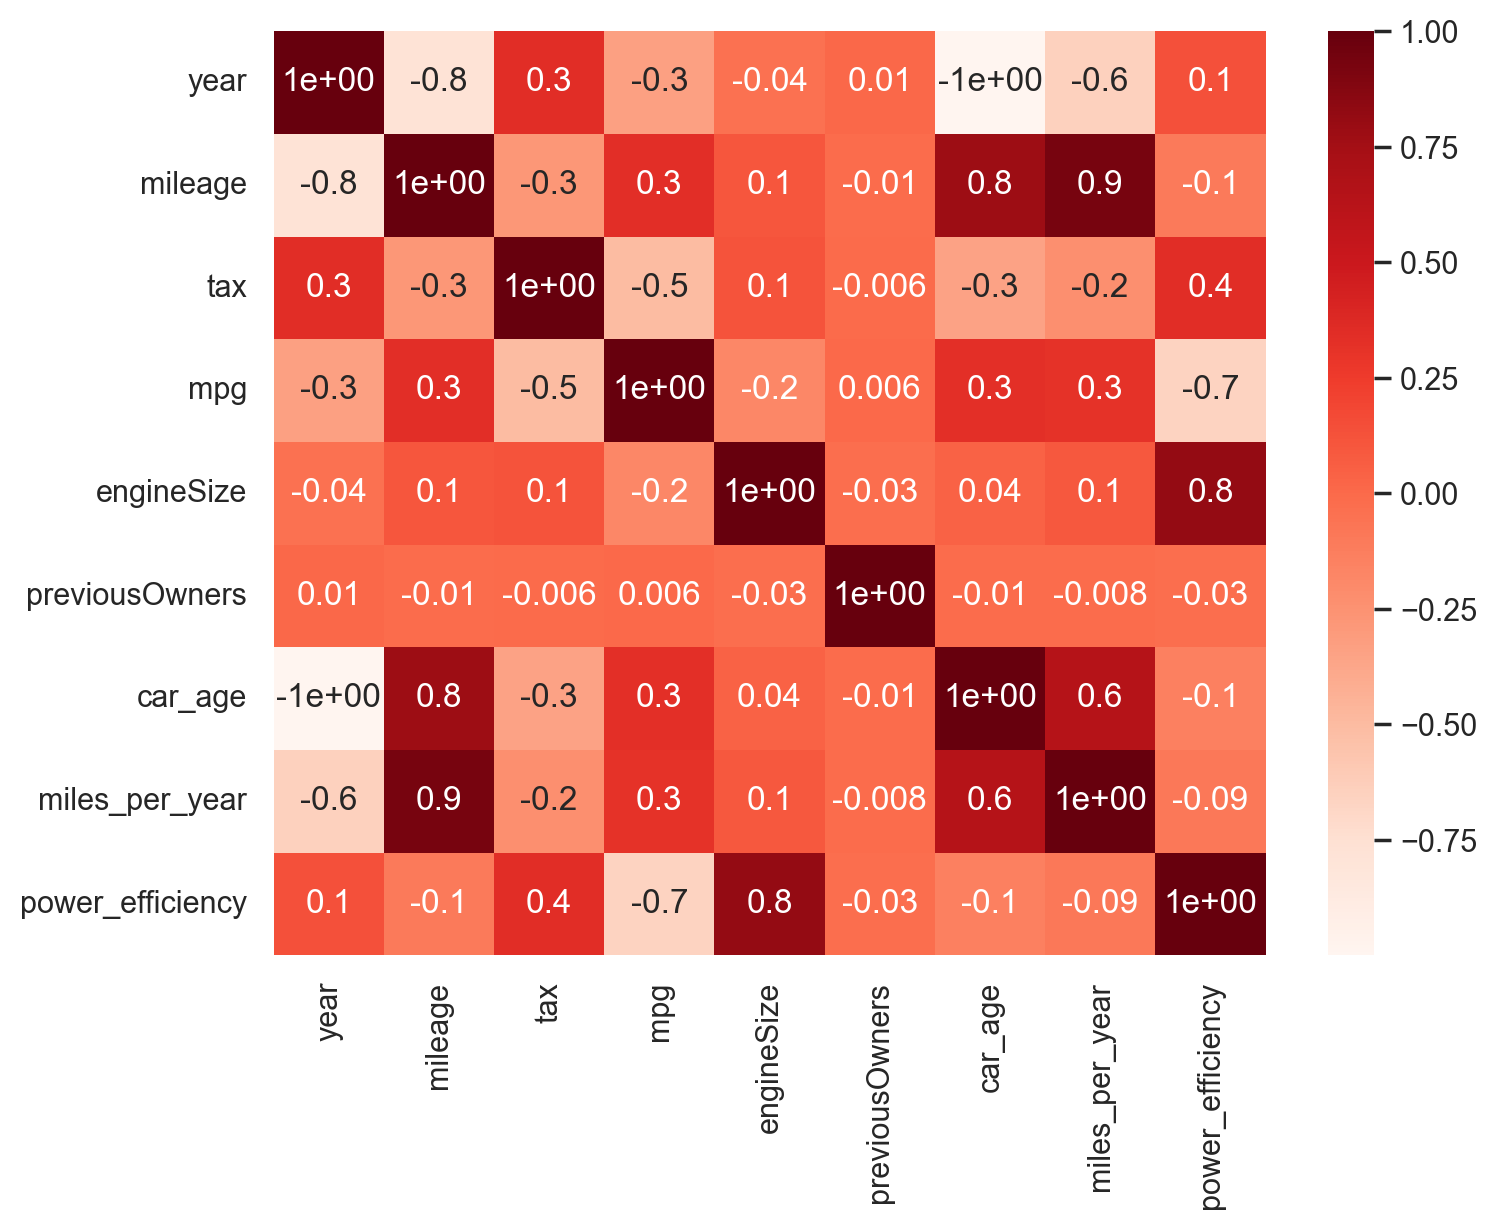

In [37]:
cor_heatmap(cor_spearman)

##### Chi2

In [38]:
X_train_cat = X_train_scaled[non_metric_features]
for var in X_train_cat:
    testindependence1(X_train_cat[var], y_train, var)

Brand is IMPORTANT for Prediction
model is IMPORTANT for Prediction
transmission is IMPORTANT for Prediction
fuelType is IMPORTANT for Prediction


#### Wrapper method

##### RFE

In [39]:

nof_list = np.arange(1, len(X_train_num_scaled.columns) + 1)
high_score = 0
nof = 0
train_score_list = []
val_score_list = []

for n in range(len(nof_list)):
    model = LinearRegression()

    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])

    X_train_rfe = rfe.fit_transform(X_train_num_scaled, y_train)
    X_val_rfe = rfe.transform(X_val_num_scaled)

    model.fit(X_train_rfe, y_train)

    train_score = model.score(X_train_rfe, y_train)
    train_score_list.append(train_score)

    val_score = model.score(X_val_rfe, y_val)
    val_score_list.append(val_score)

    if (val_score > high_score):
        high_score = val_score
        nof = nof_list[n]

        features_to_select = pd.Series(rfe.support_, index=X_train_num_scaled.columns)

print("Optimum number of features: %d" % nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")

Optimum number of features: 9
Score with 9 features: 0.693059
Features to select: 
year                True
mileage             True
tax                 True
mpg                 True
engineSize          True
previousOwners      True
car_age             True
miles_per_year      True
power_efficiency    True
dtype: bool


ValueError: x and y must have same first dimension, but have shapes (6,) and (9,)

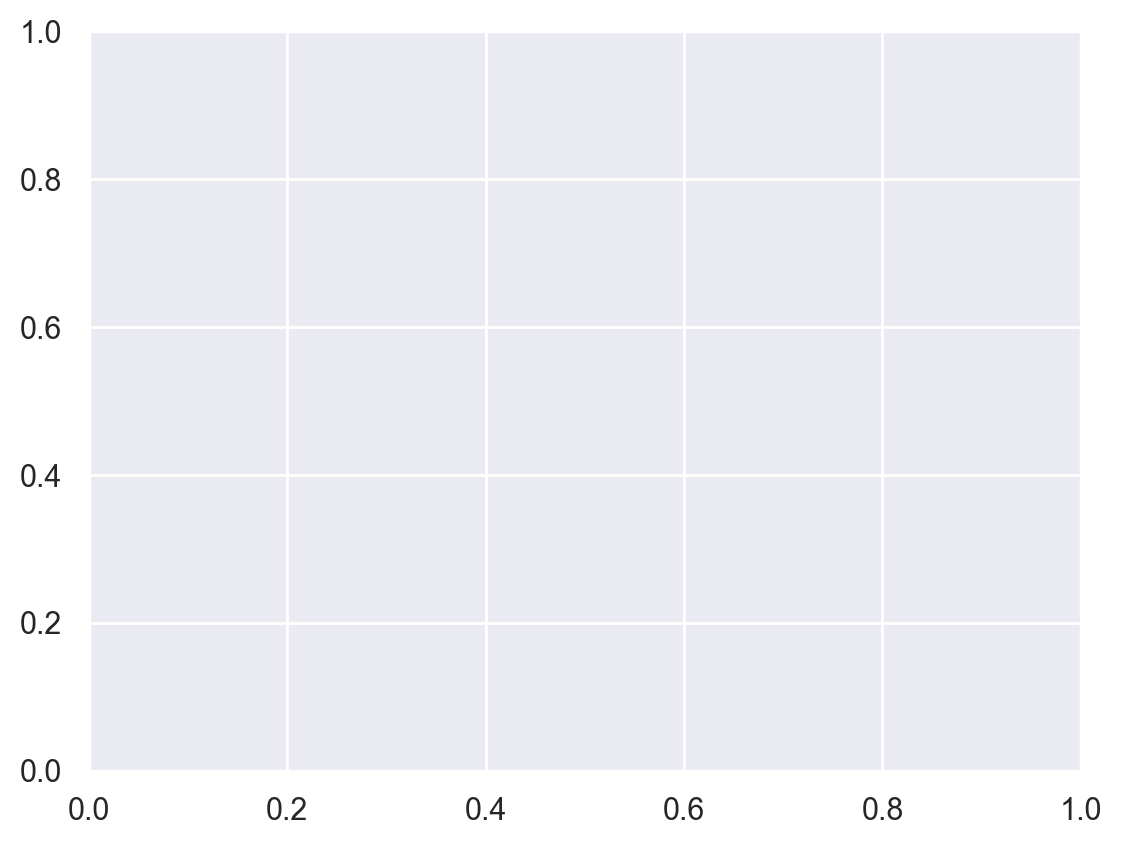

In [40]:
plt.plot(list(range(1, 7)), train_score_list, label="Score on Training Set", color='yellowgreen')
plt.plot(list(range(1, 7)), val_score_list, label="Score on Validation Set", color='dimgray')
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.legend()
plt.show()

#### Embedded method

##### Lasso Regression 

Lasso picked 8 variables and eliminated the other 1 variables
car_age            -4523.425909
mileage            -2097.193382
miles_per_year      -582.734498
mpg                 -199.418467
tax                  -46.427468
previousOwners       -26.419070
year                   0.000000
power_efficiency    1250.916228
engineSize          7300.812053
dtype: float64


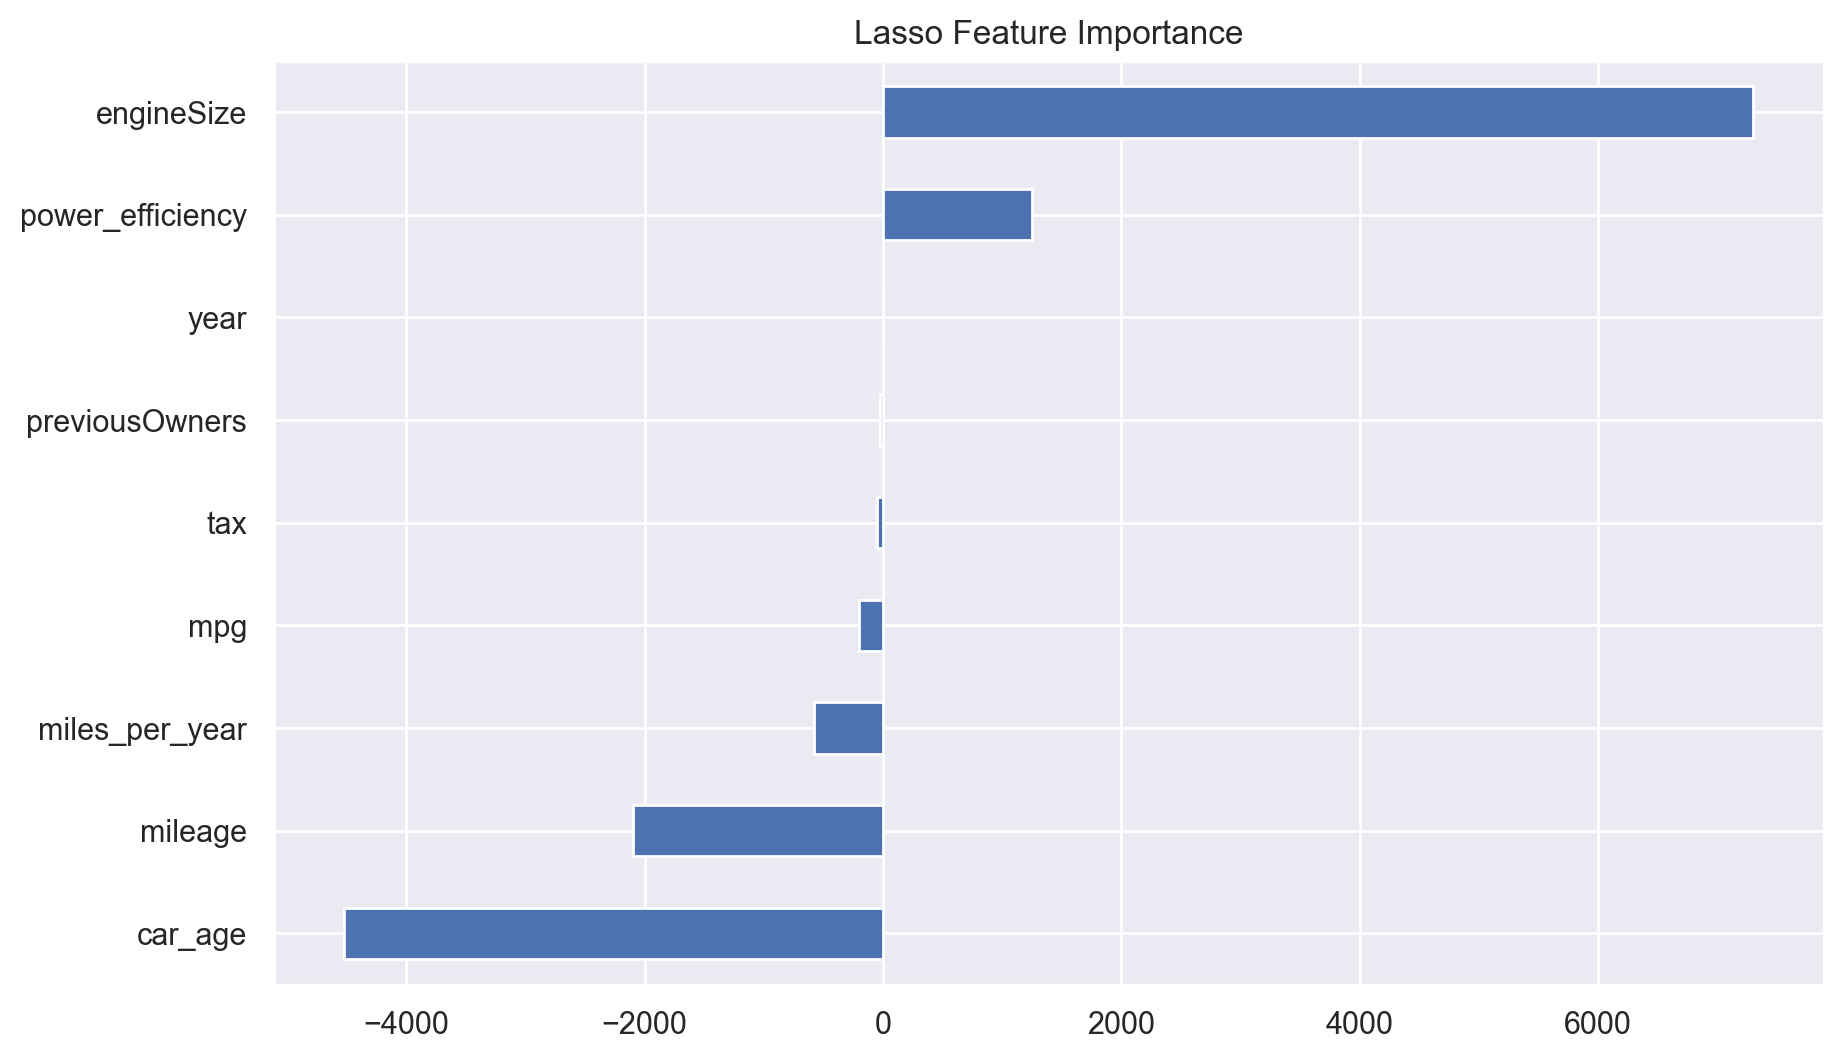

In [41]:
numeric_cols = metric_features
X_train_num_scaled = X_train_scaled[numeric_cols]

# LassoCV
reg = LassoCV(cv=5, random_state=42)
reg.fit(X_train_num_scaled, y_train)

# Coeficients
coef = pd.Series(reg.coef_, index=X_train_num_scaled.columns)

print(
    "Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " + str(sum(coef == 0)) + " variables")
print(coef.sort_values())

# Plot
plot_importance(coef, "Lasso Feature Importance")

##### Random Forest


Importance of Numeric Features:
power_efficiency    0.395462
engineSize          0.186378
mileage             0.130644
car_age             0.086058
year                0.080478
mpg                 0.056347
miles_per_year      0.033621
tax                 0.017216
previousOwners      0.013796
dtype: float64


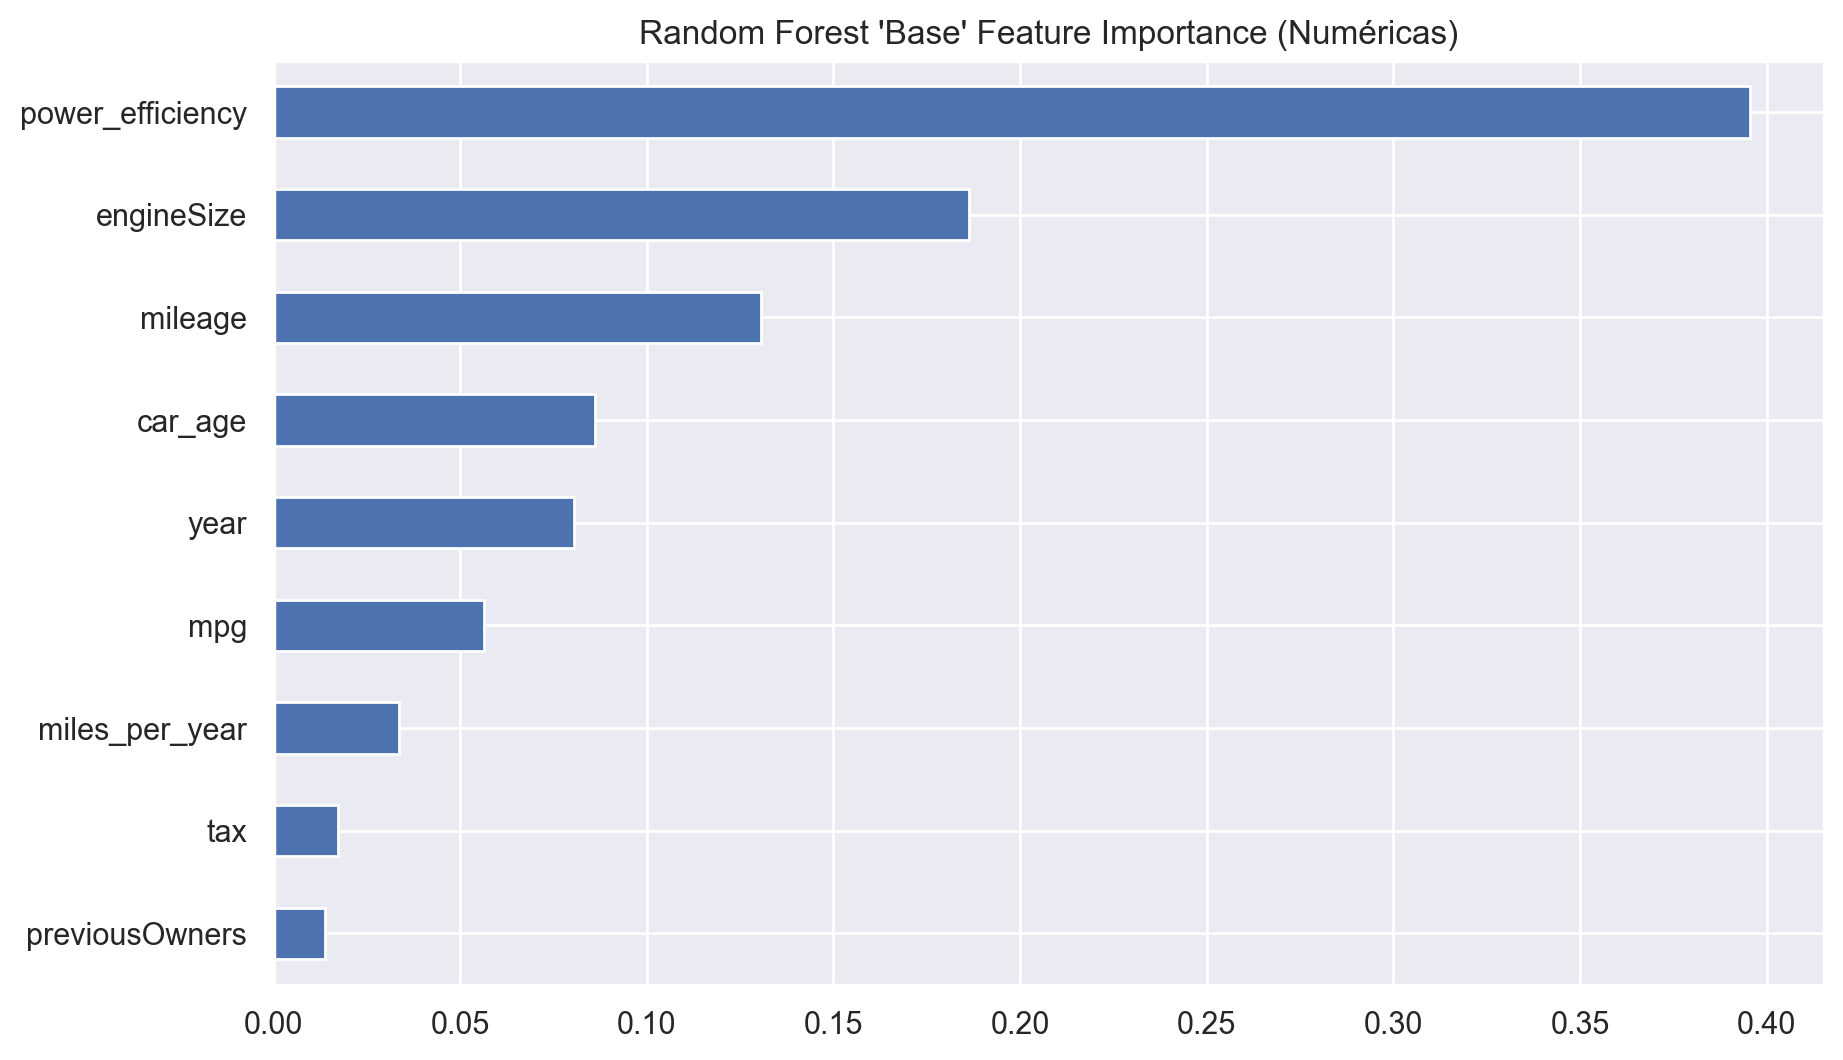

In [41]:
rf_importances_numeric = analyze_rf_importance_numeric(X_train_num_scaled, y_train, metric_features)

#### Conclusion of feature selection

Numerical Features

| Predictor       | Spearman | RFE Linear | Lasso  | Random Forest | What to do? |
|-----------------|----------|------------|--------|---------------|-------------|
| year            | Keep     | Keep       | Keep   | Keep          | Include in the model |
| mileage         | Keep     | Keep       | Keep   | Keep          | Include in the model |
| tax             | Keep     | Discard    | Discard| Discard       | Discard              |
| mpg             | Keep     | Keep       | Keep   | Keep          | Include in the model |
| engineSize      | Keep     | Keep       | Keep   | Keep          | Include in the model |
| previousOwners  | Keep     | Discard    | Discard| Discard       | Discard              |

Categorical Features

| Predictor       | Chi-Square Result                | What do |
|-----------------|----------------------------------| -- |
| Brand           | Keep                             | Include in the model |
| model           | Keep                             | Include in the model |
| transmission    | Keep                             | Include in the model |
| fuelType        | Keep                             | Include in the model |

The methods suggest removing several variables as we cansee in the tables above. However, to decide whether we should actually remove them, we will conduct a comparative performance test in Section IV. For now, we will remove hasDamage, which was already identified as constant, and paintQuality%, to prevent data leakage

## Feature Selection Conclusion:

Following a comprehensive analysis using Filter (Correlation), Wrapper (RFE), and Embedded (Lasso, Random Forest Importance) methods, we decided to refine the feature space to maximize the signal-to-noise ratio.

Dropped previousOwners: consistently flagged as irrelevant across all selection methods. Its contribution to price prediction is negligible in this dataset.

Dropped tax: Although theoretically relevant, this feature presented a high count of missing values (NaNs) and high variance. Since tax is often derived from engineSize and emissions (correlated with mpg), which are already in the model, the tax feature became redundant. Both Lasso and Random Forest marked it for discard, indicating that keeping it would introduce more noise than predictive power.

Dropped year: Removed in favor of the engineered feature car_age, which captures the temporal depreciation effect more effectively and eliminates collinearity.

Action: These features were removed from the training and testing sets to improve model generalization and stability, especially for the Neural Network (MLP) component of our Stacking Regressor.

It's noteworthy that the four main numerical features (engineSize, mileage, year, mpg) collectively represent 96.528% (0.4561 + 0.2260 + 0.1851 + 0.0980) of the model's total predictive power. The other two features (tax, previousOwners) contributed only 3.472% in total, further supporting their removal from the final model.

### Model Benchmarking and Optimization

#### Test 2: pipeline with TargetEncoder

The OrdinalEncoder was not ideal for linear models. As an optimization, we switched to a pipeline featuring TargetEncoder. TargetEncoder converts categories into the mean of the target variable, providing much more informative input.

In [41]:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=10)),
    ('scaler', RobustScaler())
])
categorical_transformer = Pipeline(steps=[
    ('target_encoder', TargetEncoder(
        target_type="continuous",
        smooth="auto",
        random_state=42
    ))
])

In [42]:
#we need to remove this features as we have seen in the feature selection
#If we dont remove de variables, the tree based models work better
metric_features.remove("tax")
metric_features.remove("previousOwners")
metric_features.remove("year")

In [43]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, metric_features),
        ('cat', categorical_transformer, non_metric_features)
    ],
    #remainder='drop' removes tax and previousOwners
)

In [44]:
preprocessor.fit(X_train, y_train)

#transform all X
X_train_FINAL = preprocessor.transform(X_train)
X_val_FINAL = preprocessor.transform(X_val)
X_test_FINAL = preprocessor.transform(X_test)

In [45]:
# Combine train and validation datasets
X_combined = np.concatenate([X_train_FINAL, X_val_FINAL])
y_combined = np.concatenate([y_train, y_val])

# Create a test fold index (-1 for train, 0 for validation)
test_fold = [-1] * len(X_train_FINAL) + [0] * len(X_val_FINAL)

print('Test fold: ', len(test_fold))
print('X_combined: ', len(X_combined))
print('y_combined: ', len(y_combined))

# Define the PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

Test fold:  75973
X_combined:  75973
y_combined:  75973


##### Tuning

In [52]:
models_params= {

    'RandomForest': (
        RandomForestRegressor(random_state=42),
        {
            'n_estimators': [3000, 4000],
            'max_depth': [40, None],
            'max_features': [0.4, 0.5],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
        }
    ),

    'ExtraTrees': (
        ExtraTreesRegressor(random_state=42),
        {
            'n_estimators': [2500, 3500],
            'max_depth': [None],
            'max_features': [0.7, 0.8, 0.9],
            'min_samples_split': [2],
            'min_samples_leaf': [1]
        }
    ),

    'GradientBoosting': (
        GradientBoostingRegressor(random_state=42),
        {
            'n_estimators': [3500, 4500, 5000],
            'learning_rate': [0.01, 0.015],
            'max_depth': [10],
            'subsample': [0.65, 0.7, 0.75],
            'min_samples_leaf': [2, 3],
            'min_samples_split': [2]
        }
    ),

    'HistGradientBoosting': (
        HistGradientBoostingRegressor(random_state=42),
        {
            'learning_rate': [0.01, 0.015],
            'max_iter': [3000, 4000],
            'max_depth': [None, 20],
            'max_leaf_nodes': [127, 255],
            'l2_regularization': [0.0, 0.1],
            'min_samples_leaf': [10, 15]
        }
    )
}

best_models = tune_models(models_params, X_combined, y_combined, cv=ps, n_iter=25)

Training models:   0%|          | 0/4 [00:00<?, ?model/s]


Random Search RandomForest:   0%|          | 0/25 [00:00<?, ?it/s]



  0%|          | 0/25 [00:00<?, ?it/s]



  4%|▍         | 1/25 [06:08<2:27:21, 368.40s/it]



  8%|▊         | 2/25 [06:08<58:12, 151.83s/it]  



 20%|██        | 5/25 [06:08<14:23, 43.18s/it] 



Training models:  25%|██▌       | 1/4 [16:52<50:37, 1012.58s/model]

Melhor score RandomForest: 1301.5633
Melhor parâmetros: {'n_estimators': 4000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.4, 'max_depth': 40}






Random Search ExtraTrees:   0%|          | 0/25 [00:00<?, ?it/s]




  0%|          | 0/25 [00:00<?, ?it/s]




  4%|▍         | 1/25 [03:02<1:13:02, 182.60s/it]




  8%|▊         | 2/25 [03:02<28:51, 75.29s/it]   




 16%|█▌        | 4/25 [03:02<09:50, 28.12s/it]




 20%|██        | 5/25 [03:13<09:22, 28.12s/it]




Training models:  50%|█████     | 2/4 [32:53<32:44, 982.00s/model] 

Melhor score ExtraTrees: 1319.9691
Melhor parâmetros: {'n_estimators': 3500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.7, 'max_depth': None}







Random Search GradientBoosting:   0%|          | 0/25 [00:00<?, ?it/s]





  0%|          | 0/25 [00:00<?, ?it/s]





  4%|▍         | 1/25 [18:14<7:17:47, 1094.49s/it]





  8%|▊         | 2/25 [18:53<3:01:31, 473.53s/it] 





 12%|█▏        | 3/25 [20:10<1:47:17, 292.59s/it]





 16%|█▌        | 4/25 [21:23<1:12:04, 205.93s/it]





 20%|██        | 5/25 [23:28<58:54, 176.72s/it]  





 24%|██▍       | 6/25 [25:20<48:57, 154.62s/it]





 28%|██▊       | 7/25 [27:49<45:49, 152.73s/it]





 32%|███▏      | 8/25 [29:03<36:12, 127.78s/it]





 36%|███▌      | 9/25 [29:19<24:43, 92.70s/it] 





 40%|████      | 10/25 [30:34<21:50, 87.34s/it]





 44%|████▍     | 11/25 [30:45<14:56, 64.07s/it]





 48%|████▊     | 12/25 [31:24<12:13, 56.42s/it]





 52%|█████▏    | 13/25 [33:22<14:59, 74.98s/it]





 56%|█████▌    | 14/25 [33:28<09:55, 54.12s/it]





 60%|██████    | 15/25 [34:35<09:41, 58.16s/it]





 64%|██████▍   | 16/25 [35:05<07:27, 49.74s/it]





 68%|██████▊   

Melhor score GradientBoosting: 1221.7550
Melhor parâmetros: {'subsample': 0.75, 'n_estimators': 5000, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 10, 'learning_rate': 0.01}








Random Search HistGradientBoosting:   0%|          | 0/25 [00:00<?, ?it/s]






  0%|          | 0/25 [00:00<?, ?it/s]






  4%|▍         | 1/25 [00:25<10:22, 25.95s/it]






  8%|▊         | 2/25 [00:28<04:38, 12.13s/it]






 12%|█▏        | 3/25 [00:28<02:28,  6.73s/it]






 16%|█▌        | 4/25 [00:28<01:27,  4.15s/it]






 20%|██        | 5/25 [00:29<01:00,  3.02s/it]






 24%|██▍       | 6/25 [00:30<00:40,  2.15s/it]






 28%|██▊       | 7/25 [00:31<00:30,  1.67s/it]






 36%|███▌      | 9/25 [00:31<00:15,  1.02it/s]






 40%|████      | 10/25 [00:34<00:22,  1.48s/it]






 44%|████▍     | 11/25 [00:37<00:28,  2.02s/it]






 48%|████▊     | 12/25 [00:38<00:22,  1.71s/it]






 56%|█████▌    | 14/25 [00:45<00:25,  2.33s/it]






 60%|██████    | 15/25 [00:45<00:18,  1.84s/it]






 64%|██████▍   | 16/25 [00:45<00:13,  1.45s/it]






 68%|██████▊   | 17/25 [00:51<00:19,  2.49s/it]






 72%|███████▏  | 18/25 [00:51<00:13,  1.87s/it]






 76%|███████

Melhor score HistGradientBoosting: 1265.7544
Melhor parâmetros: {'min_samples_leaf': 10, 'max_leaf_nodes': 255, 'max_iter': 3000, 'max_depth': None, 'learning_rate': 0.01, 'l2_regularization': 0.1}


In [55]:
for name, search in best_models.items():
    print(f"\nModelo: {name}")
    best_mae = -search.best_score_
    print(f"Melhor MAE (cv): {best_mae:.4f}")
    print("Melhores parâmetros:")
    for param, value in search.best_params_.items():
        print(f"  {param}: {value}")

NameError: name 'best_models' is not defined

##### After Tuning with new feutures

#### GB
Best parameters: {'subsample': 0.75, 'n_estimators': 5000, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 10, 'learning_rate': 0.01}

Score GrandientBoosting: 1221.7550


#### RF
Best parameters: {'n_estimators': 2500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 25}


Score RandomForest: 1288.1314


### Extra Trees
Best parameters: {'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.7, 'max_depth': 40}


Score ExtraTress:  1276.9590


### Hist GB
Best parameters: {'min_samples_leaf': 10, 'max_leaf_nodes': 255, 'max_iter': 3000, 'max_depth': None, 'learning_rate': 0.01, 'l2_regularization': 0.1}

Score Hist GB: 1265.7544

##### After Tuning
#### GF
Best parameters: {'subsample': 0.7, 'n_estimators': 3500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'learning_rate': 0.01}

Score GrandientBoosting: 1221.1257

#### RF
Best parameters:{'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.4, 'max_depth': 22}

Score RandomForest: 1272.7635


### Extra Trees
Best parameters: {'n_estimators': 1500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.8, 'max_depth': None}

Score ExtraTress: 1275.1283

### MLP
Best parameters: {'solver': 'adam', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (50, 40, 30), 'early_stopping': True, 'alpha': 0.001, 'activation': 'relu'}

Score MLPRegressor: 2064.2997


##### Model Evaluation

In [46]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(alpha=0.1, random_state=42),
    "Ridge": Ridge(alpha=0.1, random_state=42),
    "Linear SVR": LinearSVR(random_state=42, max_iter=3000, dual="auto"),
    "Random Forest": RandomForestRegressor(n_estimators=2500, max_depth=25, max_features=0.5, min_samples_leaf=1,min_samples_split=5, n_jobs=-1, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(learning_rate=0.01, max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=5000, subsample=0.75,random_state=42),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(50,40,30), learning_rate_init=0.001, activation='relu',solver='adam', early_stopping=True, alpha=0.001, random_state=42),
    "Extra Trees": ExtraTreesRegressor(n_estimators= 2000, min_samples_split= 5, min_samples_leaf= 1,  max_features= 0.7, max_depth= 40, n_jobs=-1, random_state=42),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(min_samples_leaf=  10, max_leaf_nodes= 255, max_iter=  3000, max_depth = None, learning_rate = 0.01, l2_regularization= 0.1,random_state=42),
}

In [52]:
results = running_models(models,X_train_FINAL, y_train, X_val_FINAL, y_val)


Results for: Linear Regression
  R²:   0.8255
  MAE:  2627.74
  RMSE: 4049.34

Results for: Lasso
  R²:   0.8255
  MAE:  2627.72
  RMSE: 4049.34

Results for: Ridge
  R²:   0.8255
  MAE:  2627.74
  RMSE: 4049.34

Results for: Linear SVR
  R²:   0.6666
  MAE:  3743.62
  RMSE: 5597.73

Results for: Random Forest
  R²:   0.9519
  MAE:  1288.13
  RMSE: 2125.84

Results for: Gradient Boosting
  R²:   0.9575
  MAE:  1221.75
  RMSE: 1999.00

Results for: MLPRegressor
  R²:   0.8774
  MAE:  2116.29
  RMSE: 3394.87

Results for: Extra Trees
  R²:   0.9532
  MAE:  1276.96
  RMSE: 2097.73

Results for: Hist Gradient Boosting
  R²:   0.9530
  MAE:  1265.75
  RMSE: 2101.89


In [53]:
results_2 = dict_to_results_df(results, sort_by="MAE", ascending=True, display_df=True)

Model       R²      MAE     RMSE
0       Gradient Boosting  0.95748  1221.75  1999.00
1  Hist Gradient Boosting  0.95299  1265.75  2101.89
2             Extra Trees  0.95318  1276.96  2097.73
3           Random Forest  0.95192  1288.13  2125.84
4            MLPRegressor  0.87737  2116.29  3394.87
5                   Lasso  0.82553  2627.72  4049.34
6                   Ridge  0.82553  2627.74  4049.34
7       Linear Regression  0.82553  2627.74  4049.34
8              Linear SVR  0.66660  3743.62  5597.73

In [54]:
feature_names = preprocessor.get_feature_names_out()
clean_names = [name.split('__')[-1] for name in feature_names]
models_names = ["Gradient Boosting", "Random Forest", "Extra Trees"]
for name in models_names:
    print("\n")
    print(name)
    fi = pd.Series(models[name].feature_importances_, index=clean_names).sort_values(ascending=False)
    print(fi.head(15))



Gradient Boosting
model               0.461517
power_efficiency    0.177854
car_age             0.149441
mileage             0.094879
engineSize          0.043309
mpg                 0.028102
miles_per_year      0.014937
Brand               0.014125
transmission        0.012292
fuelType            0.003545
dtype: float64


Random Forest
model               0.333672
power_efficiency    0.195644
car_age             0.124542
mileage             0.106685
engineSize          0.079437
transmission        0.057745
mpg                 0.039620
miles_per_year      0.030427
Brand               0.028206
fuelType            0.004022
dtype: float64


Extra Trees
model               0.236968
transmission        0.197179
mileage             0.114764
Brand               0.105024
car_age             0.102910
engineSize          0.094602
power_efficiency    0.066733
mpg                 0.043181
miles_per_year      0.025115
fuelType            0.013523
dtype: float64


##### Stacking

In [47]:
rf_best = models["Random Forest"]
gb_best = models["Gradient Boosting"]
et_best = models["Extra Trees"]
hgb_best = models["Hist Gradient Boosting"]

final_layer = LassoCV(
    alphas=[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
    cv=ps,
    random_state=42
)

stacking_model = StackingRegressor(
    estimators=[
        ('gb', gb_best),
        ('et', et_best),
        ('hgb',hgb_best),
        ('rf',rf_best)
    ],
    final_estimator=final_layer,
    cv=5,
    passthrough=True,
    n_jobs=1,
)

final_model_log = TransformedTargetRegressor(

    regressor=stacking_model,

    func=np.log1p,  # price to log

    inverse_func=np.expm1  # normal price

)
print("Training Final Stacking...")
final_model_log.fit(X_combined, y_combined)
print("Ready to Kaggleit!")

Training Final Stacking...
Ready to Kaggleit!


## IV. Open-Ended Section

### IV.I Ablation Study

In this section, we will measure the individual contribution of each component of our data engineering pipeline, so we tested if techniques like KNNImputer and TargetEncoder justify their complexity compared to simpler alternatives. We compared our final pipeline against two simplified variants using a stratified sample of the training data.

Scenario: 1. Baseline (KNN + TargetEnc) | R²: 0.9109
Scenario: 2. Simple Imputer (No KNN) | R²: 0.9089
Scenario: 3. Ordinal Encoder (No TargetEnc) | R²: 0.8843


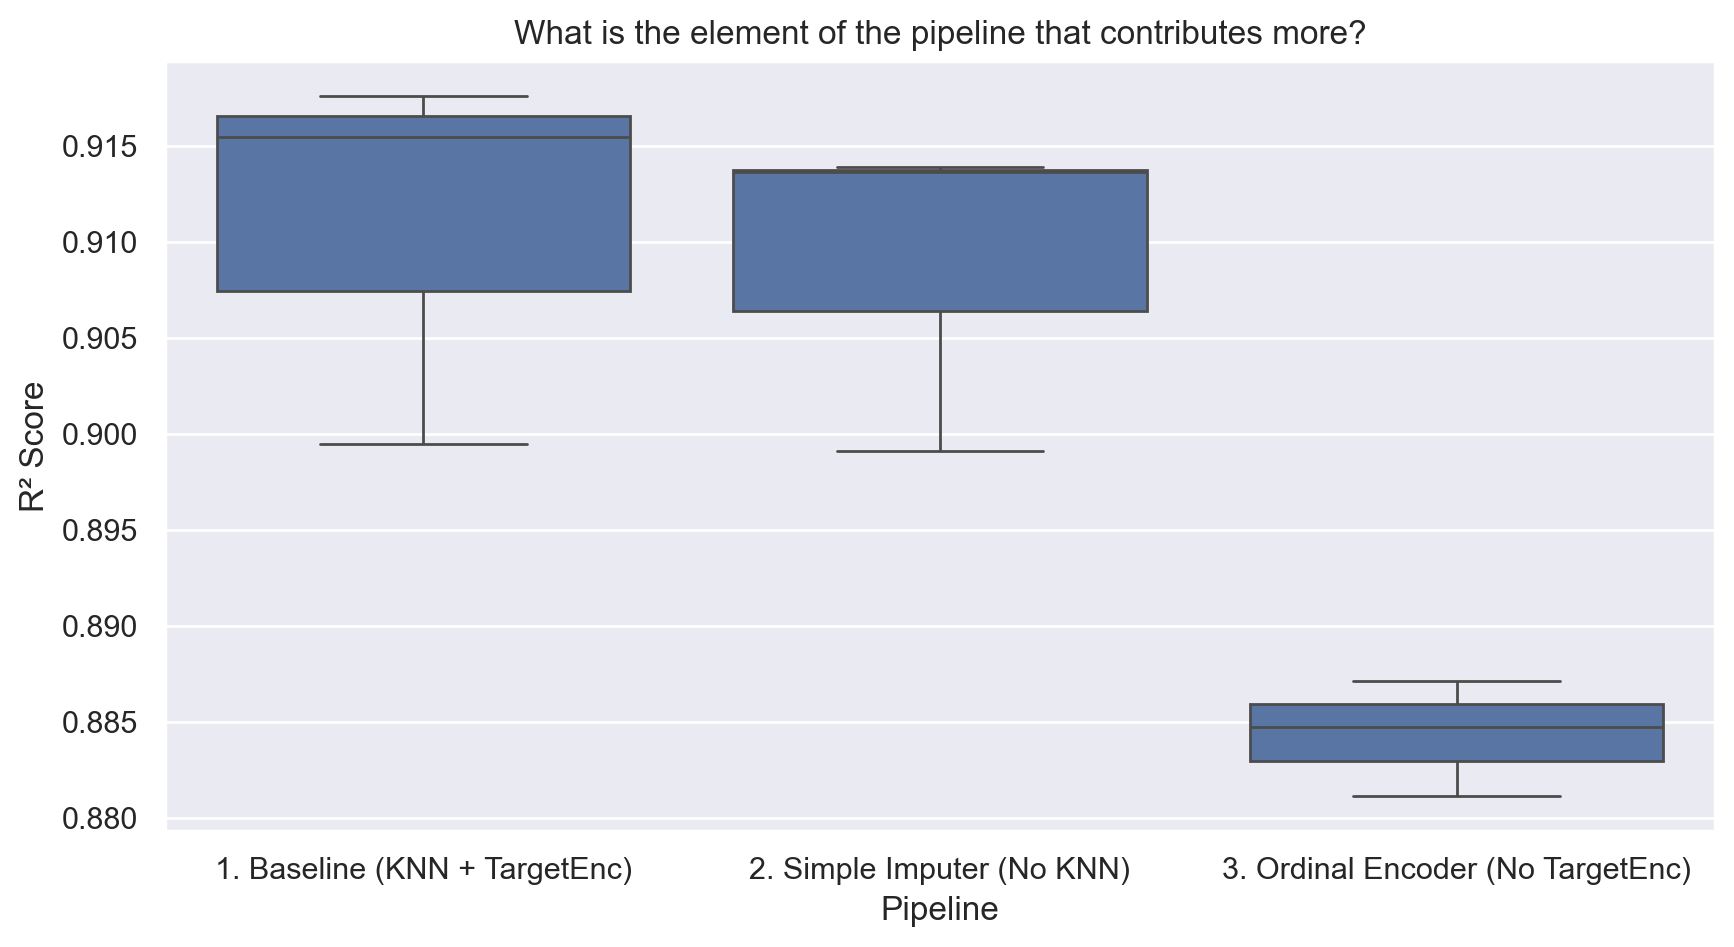

In [ ]:
# using n_smaples=10000
X_sample, y_sample = resample(X_train, y_train, n_samples=10000, random_state=42)

# using only 1 model (random forest) to test the isolated effect of pre-processing
tester_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)

# our current pipeline
# KNN Imputer + Robust Scaler + Target Encoder
pipeline_current = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', KNNImputer(n_neighbors=5)), ('scaler', RobustScaler())]), metric_features),
        ('cat', TargetEncoder(target_type="continuous"), non_metric_features)
    ]
)

# Simple Imputer + No Scaler (what is the contribution of KNN?)
pipeline_noKNN = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), metric_features), # Média simples
        ('cat', TargetEncoder(target_type="continuous"), non_metric_features)
    ]
)

# KNN Imputer + Robust Scaler + Ordinal Encoder (what is the contribution of Ordinal Encoder?)
pipeline_noTarget = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', KNNImputer(n_neighbors=5)), ('scaler', RobustScaler())]), metric_features),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), non_metric_features)
    ]
)

scenarios = {
    "1. Baseline (KNN + TargetEnc)": pipeline_current,
    "2. Simple Imputer (No KNN)": pipeline_noKNN,
    "3. Ordinal Encoder (No TargetEnc)": pipeline_noTarget
}

results = []

for name, preprocessor in scenarios.items():
    full_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', tester_model)
    ])
    
    scores = cross_val_score(full_pipeline, X_sample, y_sample, cv=3, scoring='r2')
    print(f"Scenario: {name} | R²: {scores.mean():.4f}")
    
    for score in scores:
        results.append({'Pipeline': name, 'R2 Score': score})

plt.figure(figsize=(10, 5))
sns.boxplot(data=pd.DataFrame(results), x='Pipeline', y='R2 Score')
plt.title("What is the element of the pipeline that contributes more?")
plt.ylabel("R² Score")
plt.show()

The most noticing finding is the performance drop (2.7%) observed when switching from TargetEncoder to OrdinalEncoder. This confirms that for features like model (that has hundreds of unique car models), treating categories as arbitrary numbers (1, 2, 3...) introduces noise.
The comparison between KNNImputer and SimpleImputer ended with KNN winning by a tiny margin. We still decided to keep KNN because we know that car features are connected, so we should respect their connections by looking at similar cars and prevent the model from making silly mistakes.

### IV.II Impact of dimensionality reduction

In this section, we want to validate whether the feature removal recommendations from Section III result in actual performance improvements.

We decided to use a stratified 20% sample of the training data to optimize the running time of the models. We compared the stacking regressor's performance in two different scenarios:

- First: Training with the full set of valid features.
- Second: Training after removing the features flagged as weak by the majority of the feature selection methods.

Using 15000 rows:
Stacking with all features: Medium R² = 0.9246
Stacking dropping 2 vars): Medium R² = 0.9193


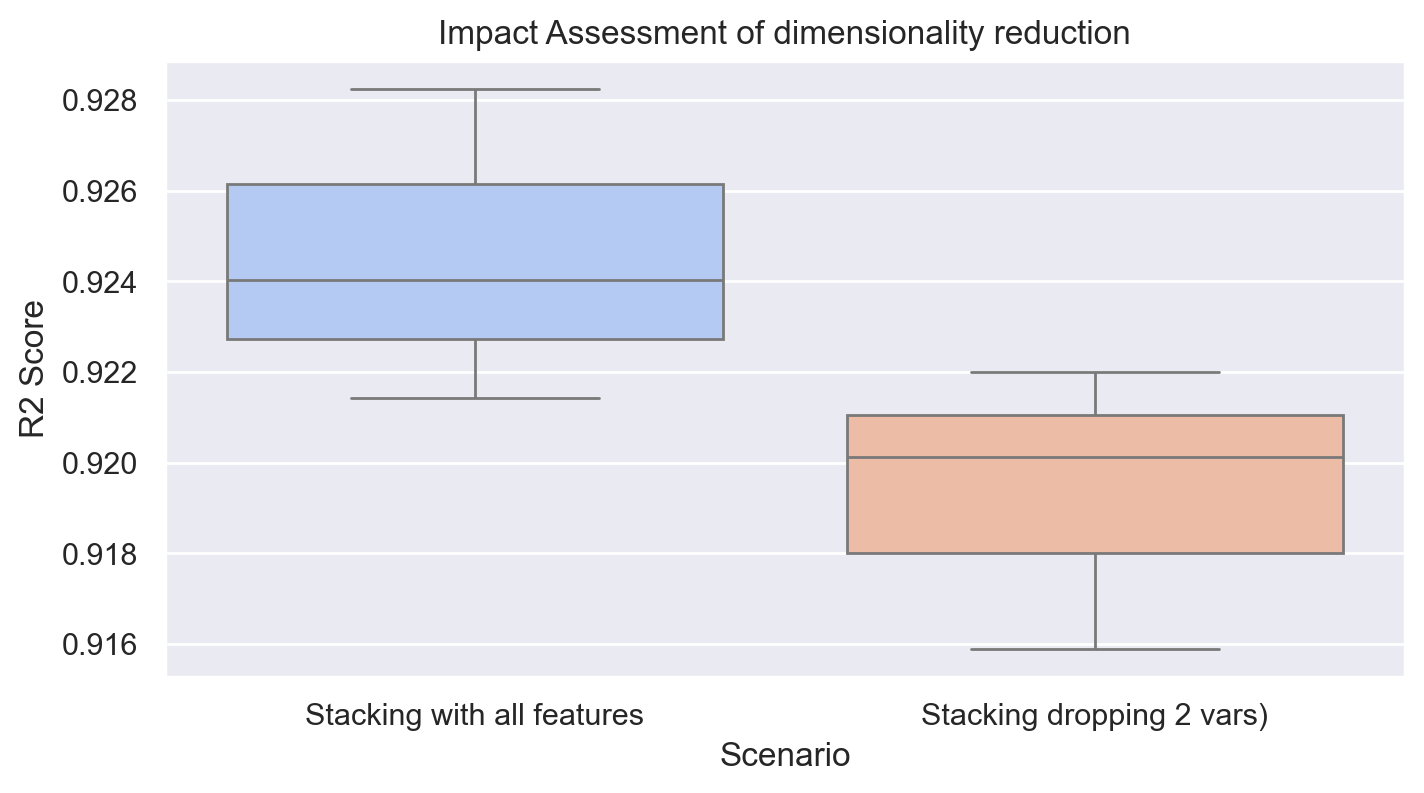

Difference on performance: 0.00522
Conclusion: we should keep all features.


In [ ]:
# to optimize running time, we changed some parameters:
# using only 15000 rows 
X_sample, y_sample = resample(X_train_FINAL, y_train, n_samples=15000, random_state=42)

# using n_estimators=50 
estimators_openendend = [
    ('rf', RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)),
    ('gb', GradientBoostingRegressor(n_estimators=50, max_depth=5, random_state=42)),
    ('et', ExtraTreesRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)),
    ('mlp', MLPRegressor(hidden_layer_sizes=(50, 30), max_iter=200, random_state=42))
]

stacking_fast = StackingRegressor(
    estimators=estimators_openendend,
    final_estimator=LinearRegression(),
    n_jobs=-1,
    cv=3 # a lower CV
)

# with no feature selection
X_all = X_sample

# with suggested feature selection
weak_features = ['previousOwners', 'tax'] 

cols_indices_to_keep = [i for i, col in enumerate(X_train.columns) 
                        if col not in weak_features]
X_reduced = X_sample[:, cols_indices_to_keep]


scenarios = {
    "Stacking with all features": X_all,
    f"Stacking dropping {len(weak_features)} vars": X_reduced
}

results = []
print(f"Using {len(X_sample)} rows:")

for name, X_data in scenarios.items():
    
    scores = cross_val_score(stacking_fast, X_data, y_sample, cv=3, scoring='r2')
    
    print(f"{name}: Medium R² = {scores.mean():.4f}")
    
    for score in scores:
        results.append({'Scenario': name, 'R2 Score': score})

df_results = pd.DataFrame(results)

plt.figure(figsize=(8, 4))
sns.boxplot(data=df_results, x='Scenario', y='R2 Score')
plt.title('Impact Assessment of dimensionality reduction')
plt.show()

# r^2 results
mean_all = df_results[df_results['Scenario'].str.contains("all")]['R2 Score'].mean()
mean_red = df_results[df_results['Scenario'].str.contains("dropping")]['R2 Score'].mean()

print(f"Difference on performance: {mean_all - mean_red:.5f}")
if mean_all > mean_red:
    print("Conclusion: we should keep all features.")
else:
    print("Conclusion: we should remove the suggested features.")

As we can see, the results contradict the theoretical suggestions from the linear feature selection methods. Removing the flagged variables caused a performance degradation of approximately 0.52% in the R² score.

This shows that while variables like tax may have weak linear correlations with price (and because of that being rejected by lasso/ spearman), they contain non-linear information or other effects that our tree-based ensemble models (random forest, gradient boosting and extra trees) rely on for some accuracy gains.

Therefore, we decided to retain all original features in the final deployment pipeline to maximize predictive accuracy.

### IV.III Residual Analysis & Segmentation

In this section, we wanted to go beyond the global accuracy score and understand exactly where our model fails. We suspected that the model might struggle more with high-end vehicles simply because we have fewer examples of them in our training data compared to common cars. To test this, we calculated the average error (MAE) for three different market segments: economic cars (under 15.000€), mid-range (15.000-30.000€), and luxury cars (over 30.000€).

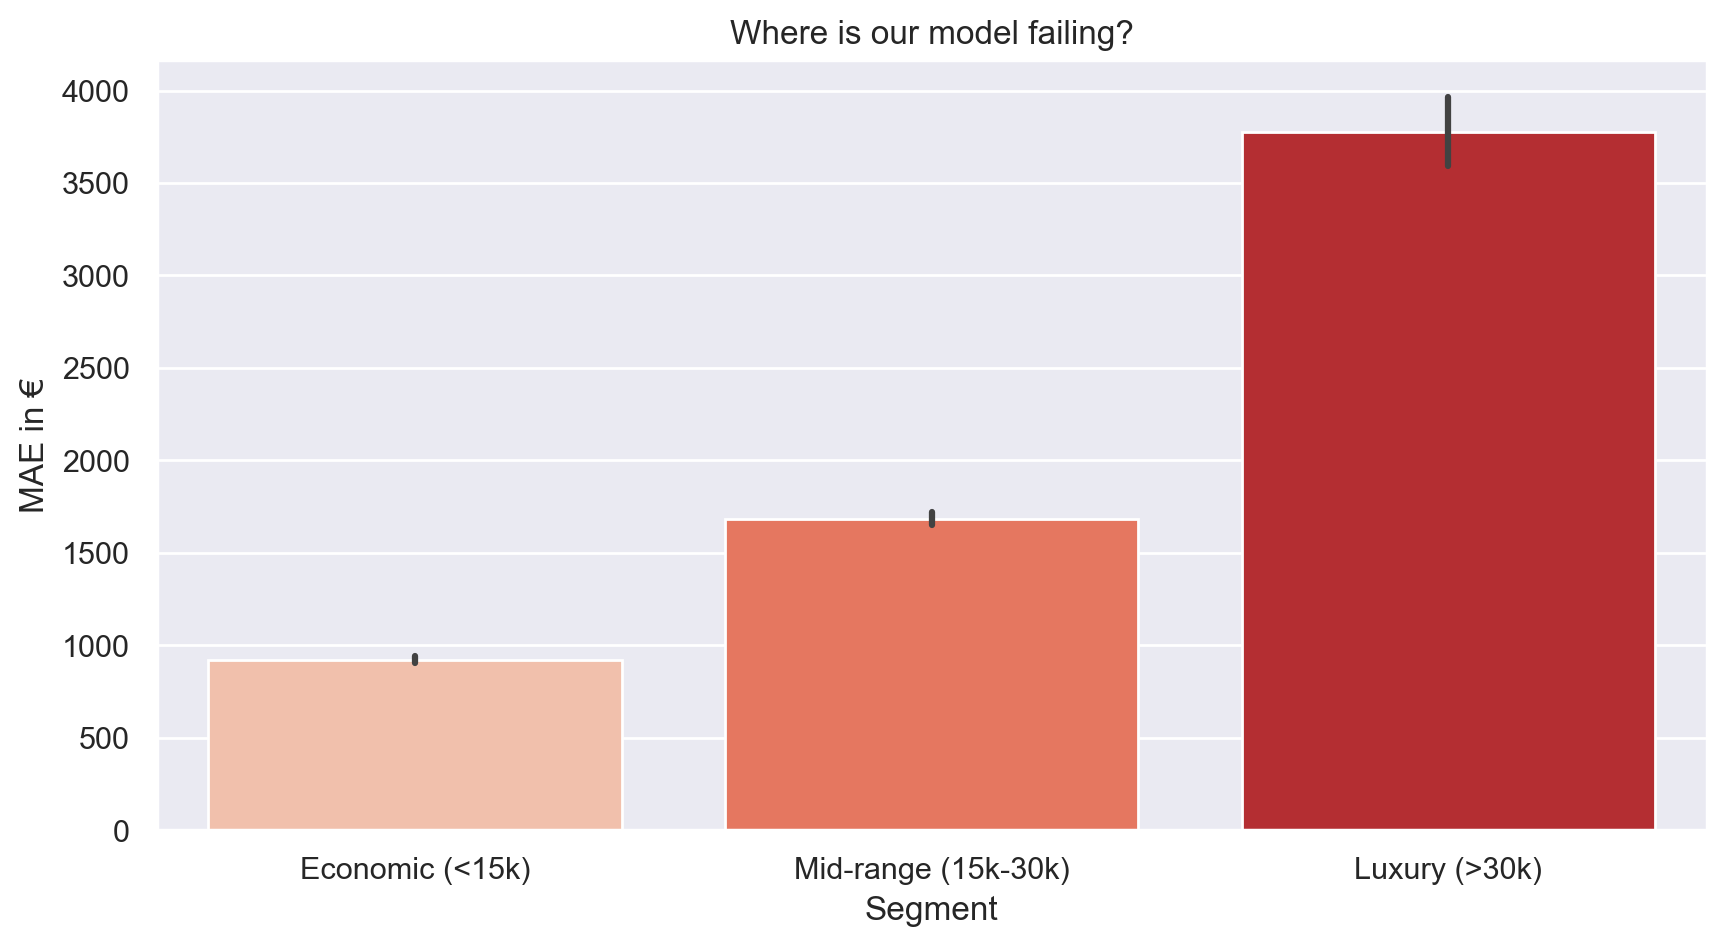

Conclusion:
Segment
Economic (<15k)         923.56€
Mid-range (15k-30k)    1684.29€
Luxury (>30k)          3773.73€
Name: MAE, dtype: object


In [ ]:
# to optimize running time, we changed some parameters:
# n_samples=15000
X_sample, y_sample = resample(X_train_FINAL, y_train, n_samples=15000, random_state=42)

analysis_model = clone(stacking_model) 
analysis_model.fit(X_sample, y_sample)

y_pred_analysis = analysis_model.predict(X_val_FINAL)

df_analysis = pd.DataFrame({'Real': y_val, 'Prediction': y_pred_analysis})
df_analysis['MAE'] = np.abs(df_analysis['Real'] - df_analysis['Prediction'])

# price segments
bins = [0, 15000, 30000, 1000000]
labels = ['Economic (<15k)', 'Mid-range (15k-30k)', 'Luxury (>30k)']
df_analysis['Segment'] = pd.cut(df_analysis['Real'], bins=bins, labels=labels)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_analysis, x='Segment', y='MAE')
plt.title("Where is our model failing?")
plt.ylabel("MAE in €")
plt.show()


print("Value of MAE in €:")
print(df_analysis.groupby('Segment')['MAE'].mean().apply(lambda x: f"{x:.2f}€"))


Our analysis confirms that the model works very well for the vast majority of the company's inventory, specifically for economic and mid-range cars. In this segment, it predicts prices with high accuracy. However, for the premium market, the fact that we have fewer examples leads to less consistent results.

## V. Deployment

### Conclusion and Kaggle submission

The Random Forest Regressor was the winner with R² = 0.9522. 

Below, we use the final pipeline and generate the 'submission.csv' file.

In [48]:
#y_test=models["Gradient Boosting"].predict(X_test_FINAL)
#y_test = best_overall_model.predict(X_test_FINAL)
y_test = final_model_log.predict(X_test_FINAL)
submission = pd.DataFrame({
    'carID': test.index,
    'price': y_test.astype("int")
})
submission.to_csv('Group23_Version81.csv', index=False)